In [1]:
#import needed libraries (although not all imported below are used in the given code)

import os
from os import listdir
from os.path import isfile, join
import sys
import codecs
import fileinput
import string
from collections import OrderedDict
import numpy as np
from pandas import DataFrame
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D
import scipy
from scipy import optimize, stats
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths,hilbert
from decimal import Decimal
import iminuit 
import csv
import cmath
import math
from math import sqrt

#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D
import iminuit
import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares


# destination to the data (input) and output folders (change according to the path on your PC)

containing_folder_path = "/home/amslivar/work/AmBe_v2/AmBe_characterization_analysis/"
path_base = containing_folder_path + "2024_GeIII_calibration_Th228_with_attenuator/"
measurement_path= path_base +'Data/'
measurement_output_path= path_base + 'Results/'

#calibration parameters
p0 = -3.617
p1 = 2.878

p0 = 0.974
p1 = 1.106

#function to count number of significant digits after comma
def number_sigdigs(x):
    digs_after_comma = str(x - math.floor(x))
    digs_after_comma = digs_after_comma[2:]
    number=0
    for c in digs_after_comma:
        if c=='0':
            number+=1
        else:
            number+=2
            break
    return number

print('numpy version', np.__version__)
print('matplotlib version', matplotlib.__version__)
print('pandas version', pd.__version__)
print('scipy version', scipy.__version__)
print('iminuit version', iminuit.__version__)

numpy version 1.21.6
matplotlib version 3.5.3
pandas version 1.1.5
scipy version 1.7.3
iminuit version 2.18.0


In [2]:
# read the data files from measurement_path folder and replace "," delimiter with "."
files_in_folder = [f for f in listdir (measurement_path) if isfile(join(measurement_path, f))]
files_in_folder.sort()

In [3]:
# read the data files and put the content into list of dataframes

numbers=np.linspace(0,8191,num=8192)
numbers=list(numbers)

import re

scan = [] #list of measurement data (in DataFrame format) extracted from scan files
files_scan=[] #list of measurement files

for f in files_in_folder:
    if "Th228_Cal_with_Atten" in f: #choose only files with names containing "Th228Calibration_with_attenuator"
        
        print(f) #prints measurement file name
        files_scan.append(f) #choose only files with names containing "Th228Calibration_with_attenuator"
        
        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list
        
for f in files_in_folder:        
    if "background" in f: #choose only files with names containing "Background"
        
        print(f) #prints measurement file name
        files_scan.append(f) #choose only files with names containing "Background"
        
        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

#Th-228 measurement time and background measurement time
t=325.66
t_bkg=71559.74

#combine background data
bkg = np.asarray(scan[1][1])
i=2
while i <len(scan):
    bkg+=np.asarray(scan[i][1])
    i+=1

#rescale background data to Th-228 measurement time
bkg=bkg/t_bkg*t

#subtract rescaled background from Th-228 data
signal=np.asarray(scan[0][1])-bkg


Th228_Cal_with_Atten.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
background_run_with_atten_04232024.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]


In [4]:
#checking that the measurement files have been read and written in the right order

i=0
while i<len(files_scan):
    print(i, files_scan[i])
    i+=1


0 Th228_Cal_with_Atten.dat
1 background_run_with_atten_04232024.dat


In [5]:
#list the Th-228 gamma peaks and their energies

Peak_name=["Pb-212", "208Tl","212Bi", "212Pb", "208Tl", "208Tl","212Bi", "208Tl","212Bi", "208Tl","212Bi","212Bi", "208Tl", "212Bi", "208Tl", "212Bi", "208Tl SE"]
Peak_energy=[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]
Peak_channel=[]
Peak_channel_err=[]
Sigma_channel=[]
Sigma_channel_err=[]

p=0

In [6]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1


plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65

from decimal import Decimal
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D
import iminuit
import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Pb-212 peak, 115.183 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.958 (chi2/ndof = 1.0)    │              Nfcn = 758              │
│ EDM = 1.06e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │ 7.1416e2  │ 0.0000e2  │            │            │         │         │       │
│ 1 │ sig    │  -7.1001  │  0.0000   │            │            │         │         │       │
│ 2 │ mu     │ 1.1516e2  │ 0.0000e2  │            │            │         │         │       │
│ 3 │ offset │ 2.5537e2  │ 0.0000e2  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

<ValueView A=714.1621585220888 sig=-7.10008777722383 mu=115.16345282624778 offset=255.36560677906405>
<ErrorView A=0.0 sig=0.0 mu=0.0 offset=0.0>
(714.1621585220888, -7.10008777722383, 115.16345282624778, 255.36560677906405)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56afe8860> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:149: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56afe8860> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

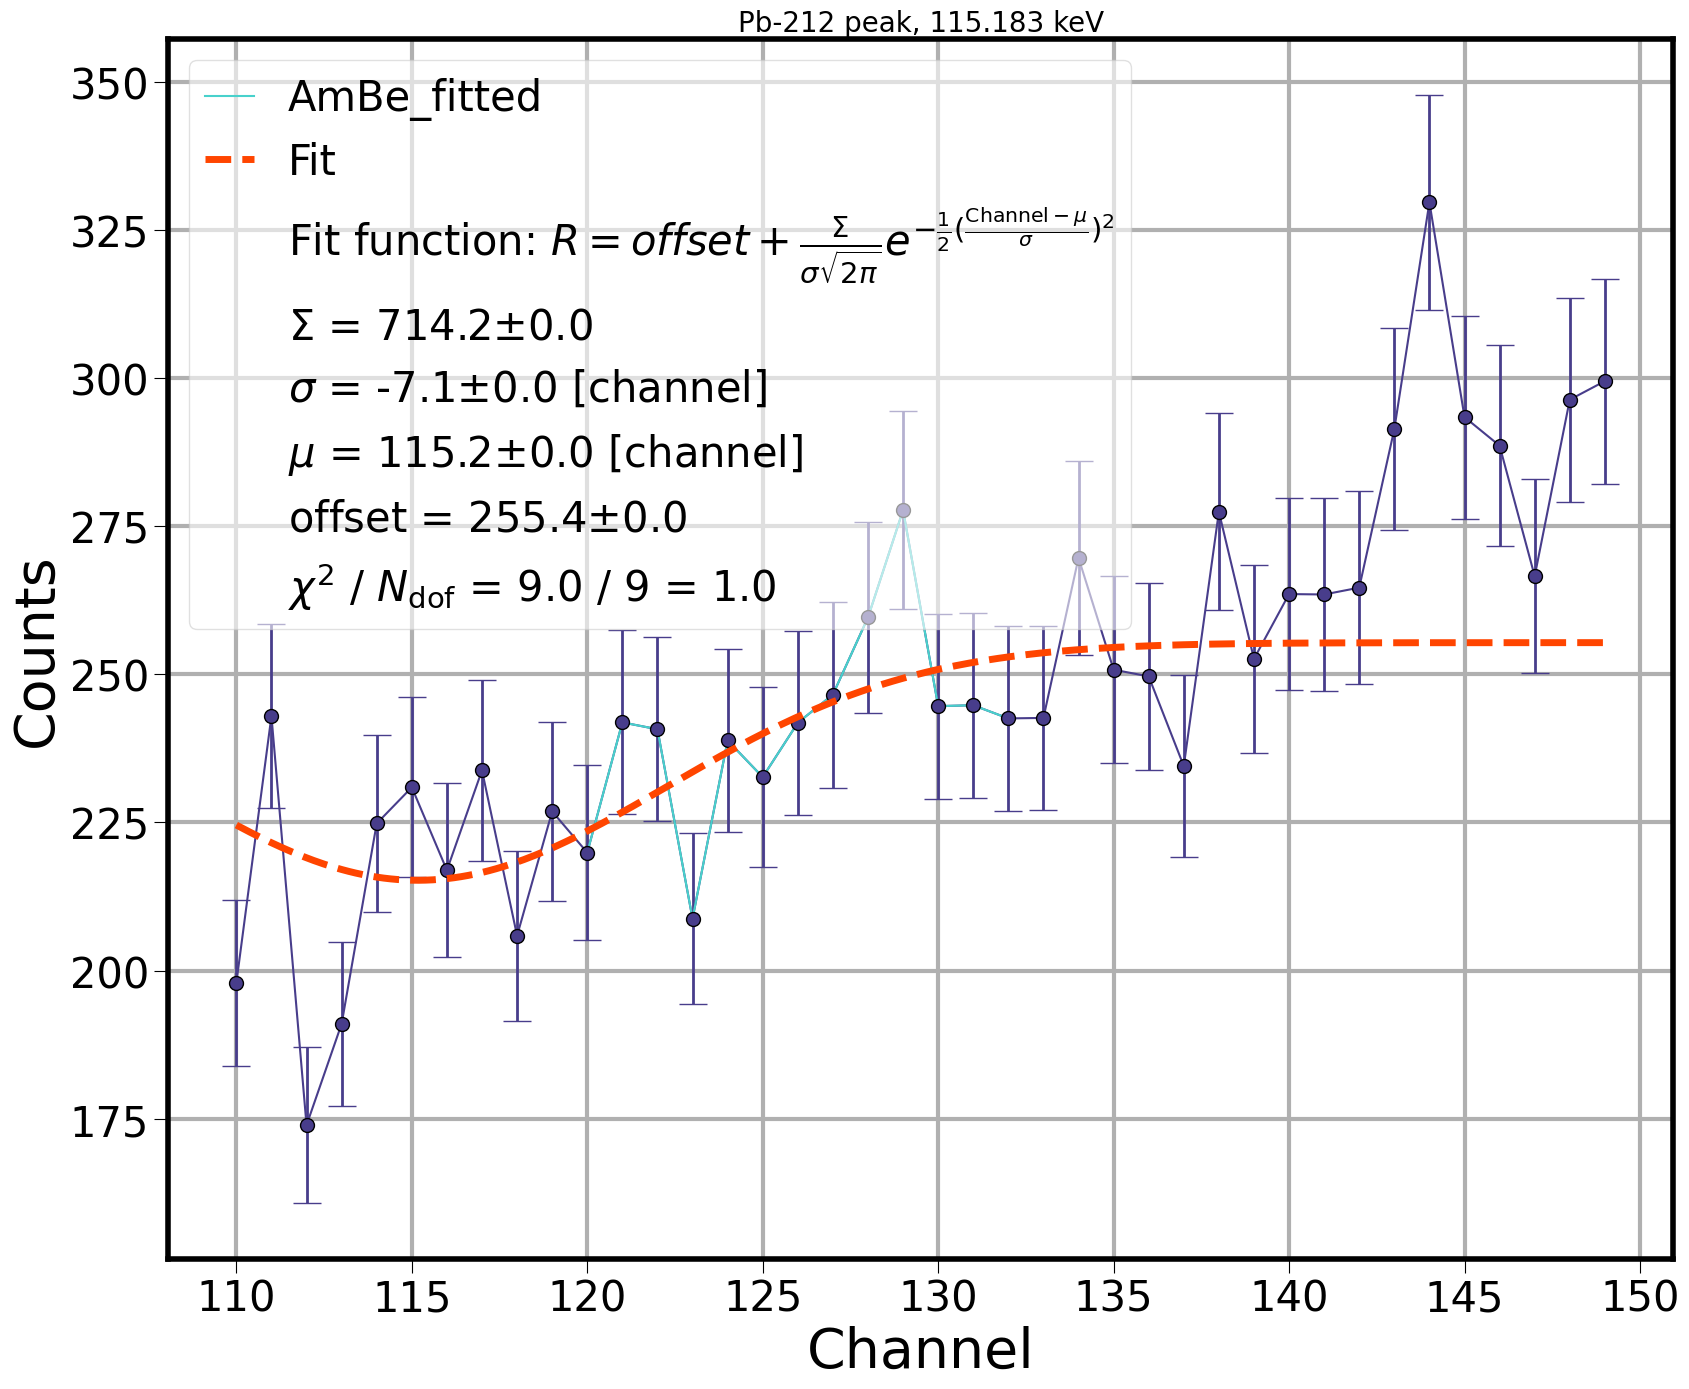

In [7]:

plt.figure()
fig, ax1 = plt.subplots()
plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
fig.tight_layout()

ch1=120
ch2=133
ch3=110
ch4=150

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]

Data, = ax1.plot(channels, rate_no_bkg, color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())

#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 500
mu00 = 127
sig00 = 5 
offset00 = 300

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)

#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist )

#run minimization  
minuit.migrad()

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)

handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]

for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 277.371 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 185.8 (chi2/ndof = 16.9)   │              Nfcn = 250              │
│ EDM = 1.78e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    1e3    │    0e3    │            │            │         │         │       │
│ 1 │ sig    │-9.2197e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 2 │ mu     │ 3.5385e2  │ 0.0000e2  │            │            │         │         │       │
│ 3 │ offset │  1.157e2  │  0.000e2  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

<ValueView A=1000.0 sig=-0.921965866153009 mu=353.8469103500372 offset=115.70325816434507>
<ErrorView A=0.0 sig=0.0 mu=0.0 offset=0.0>
(1000.0, -0.921965866153009, 353.8469103500372, 115.70325816434507)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa5690a22b0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:152: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa5690a22b0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

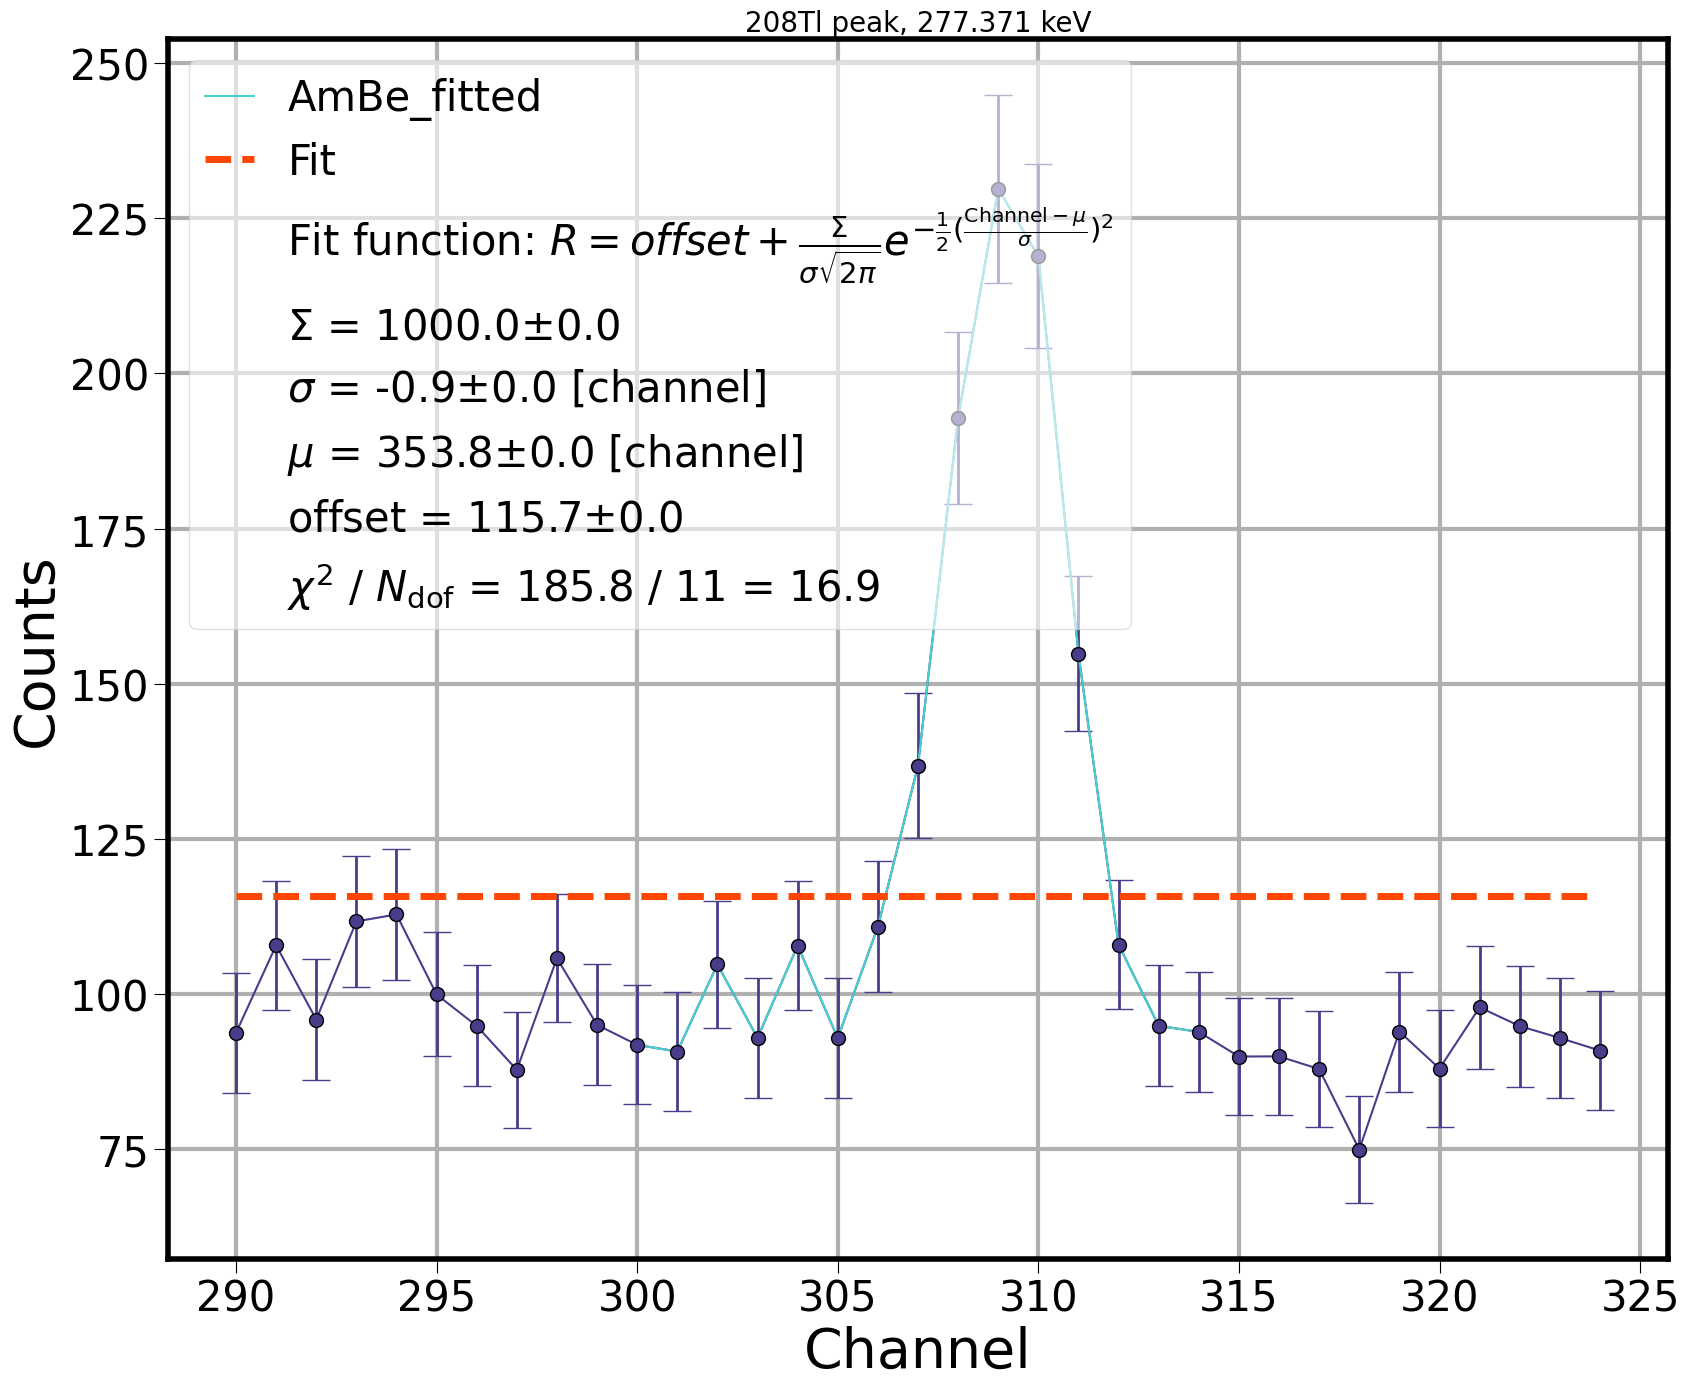

In [8]:


plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
fig.tight_layout()

ch1=300
ch2=315
ch3=290
ch4=325

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]

Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

handlelist.append(Data)
labellist.append(Data.get_label())

#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 1000
mu00 = 307
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)

#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist )     

#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)

handlelist.append(Fit)
labellist.append(Fit.get_label())

text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'

text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]


for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 288.2 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.176 (chi2/ndof = 0.6)    │              Nfcn = 688              │
│ EDM = 0.0111 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.000e3  │  0.004e3  │            │            │         │         │       │
│ 1 │ sig    │   0.03    │   0.20    │            │            │         │         │       │
│ 2 │ mu     │   311.9   │    0.7    │            │            │         │         │       │
│ 3 │ offset │   92.4    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │    13.1 -0.0184  0.0618  -0.048 │
│    sig │ -0.0184  0.0418  -0.141   0.101 │
│     mu │  0.0618  -0.141   0.475  -0.339 │
│ offset │  -0.048   0.101  -0.339   0.248 │
└────────┴─────────────────────────────────┘

<ValueView A=1000.0044859541493 sig=0.03256441751025158 mu=311.8810125249688 offset=92.38277338132707>
<ErrorView A=3.615594072489113 sig=0.20438038421802907 mu=0.688849232431589 offset=0.4977902146619866>
(1000.0044859541493, 0.03256441751025158, 311.8810125249688, 92.38277338132707)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56d032400> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56d032400> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

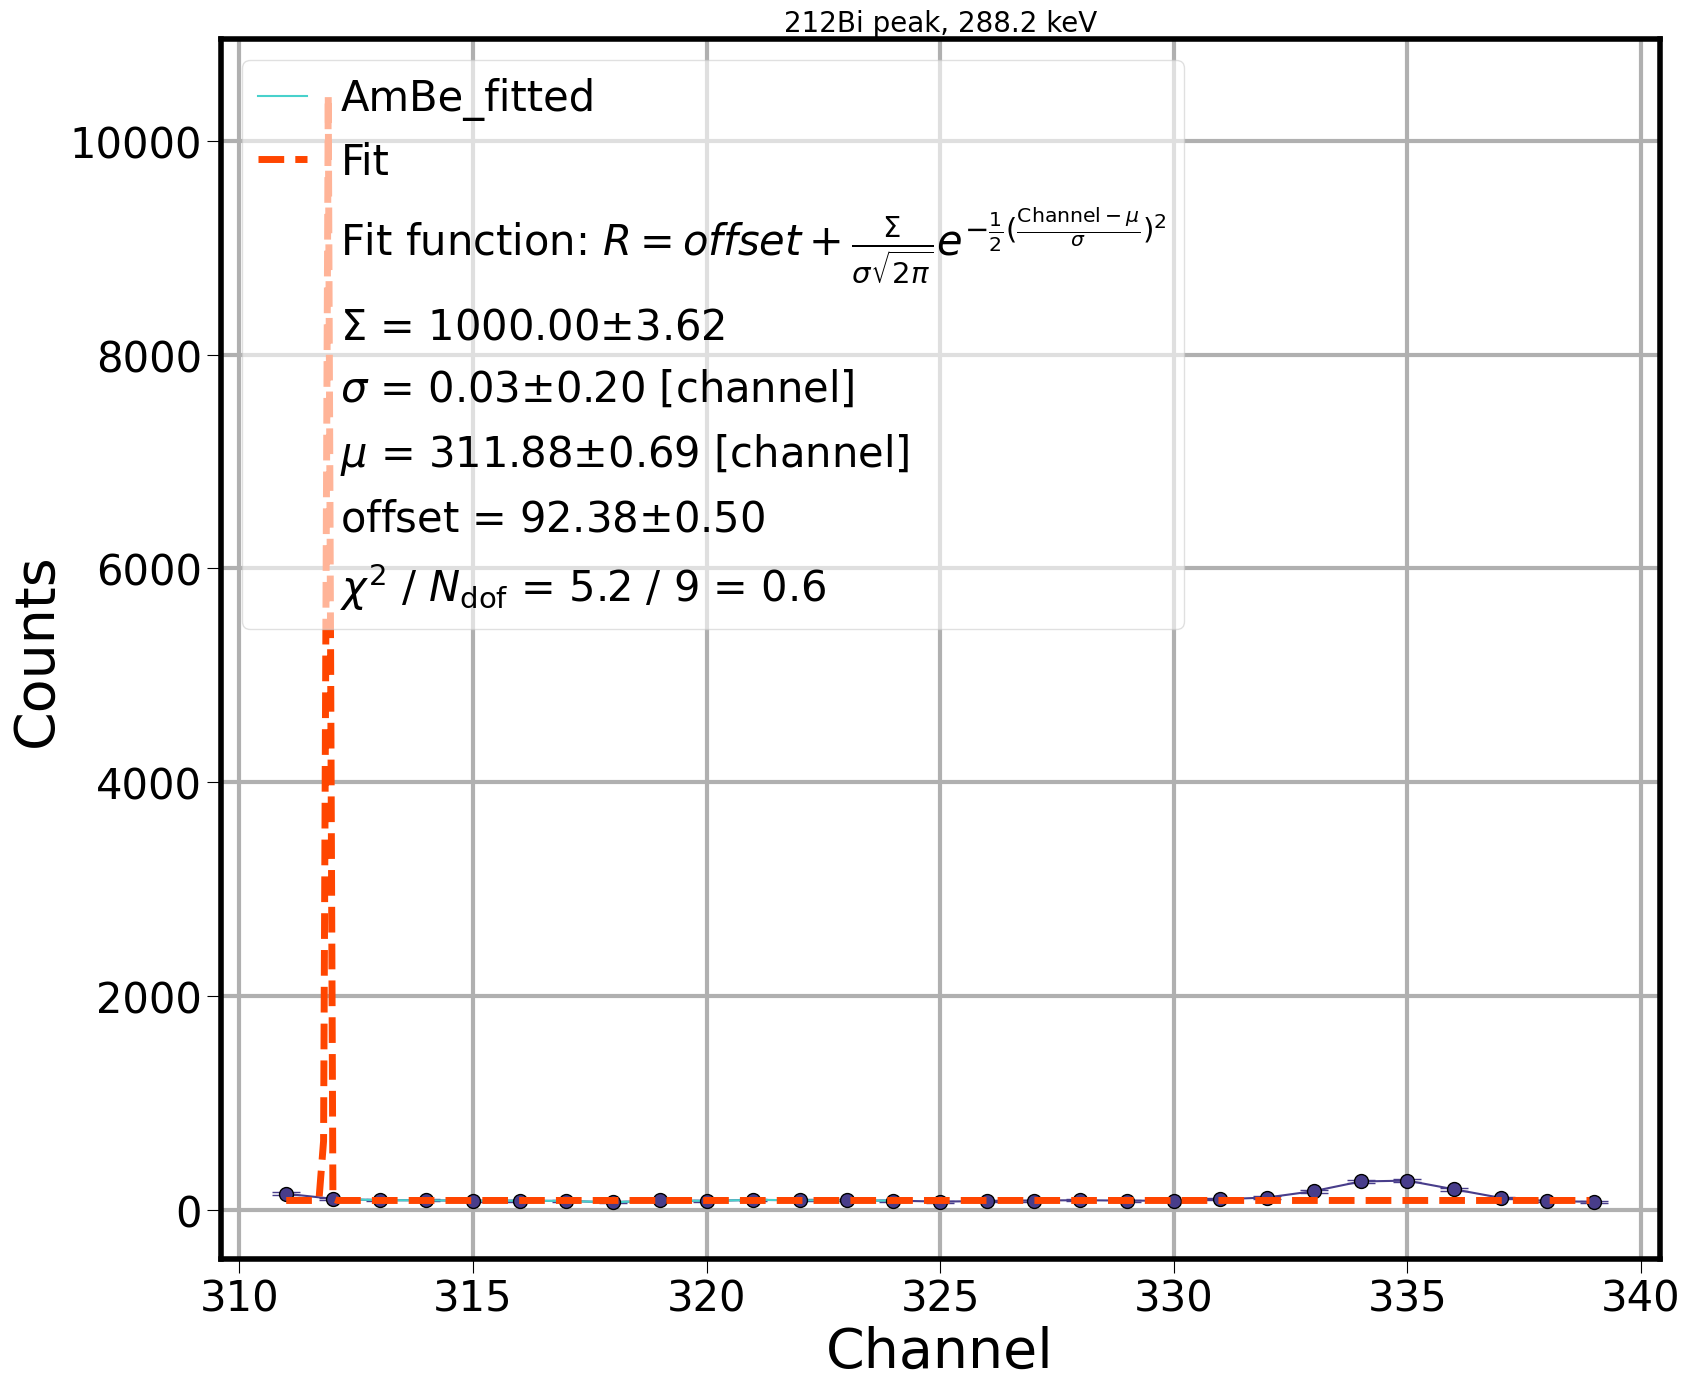

In [9]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()

ch1=312
ch2=325
ch3=311
ch4=340

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]

Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

handlelist.append(Data)
labellist.append(Data.get_label())

#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 1000
mu00 = 317
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)

#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 

#run minimization  
minuit.migrad()

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)

handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'

text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]

for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Pb peak, 300.087 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 310.8 (chi2/ndof = 28.3)   │              Nfcn = 163              │
│ EDM = 3.4e-17 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.000e3  │  0.002e3  │            │            │         │         │       │
│ 1 │ sig    │    7.3    │    2.0    │            │            │         │         │       │
│ 2 │ mu     │    397    │     2     │            │            │         │         │       │
│ 3 │ offset │   110.5   │    1.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │         4 -0.000436  1.71e-07  3.18e-07 │
│    sig │ -0.000436         4  -0.00157  -0.00292 │
│     mu │  1.71e-07  -0.00157         4  1.15e-06 │
│ offset │  3.18e-07  -0.00292  1.15e-06      2.59 │
└────────┴─────────────────────────────────────────┘

<ValueView A=1000.0 sig=7.279191656702619 mu=396.95460701224056 offset=110.53852975024502>
<ErrorView A=1.9996503909316097 sig=1.9999989907128224 mu=1.9996505338693273 offset=1.6100024730181408>
(1000.0, 7.279191656702619, 396.95460701224056, 110.53852975024502)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a45fe48> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:172: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a45fe48> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

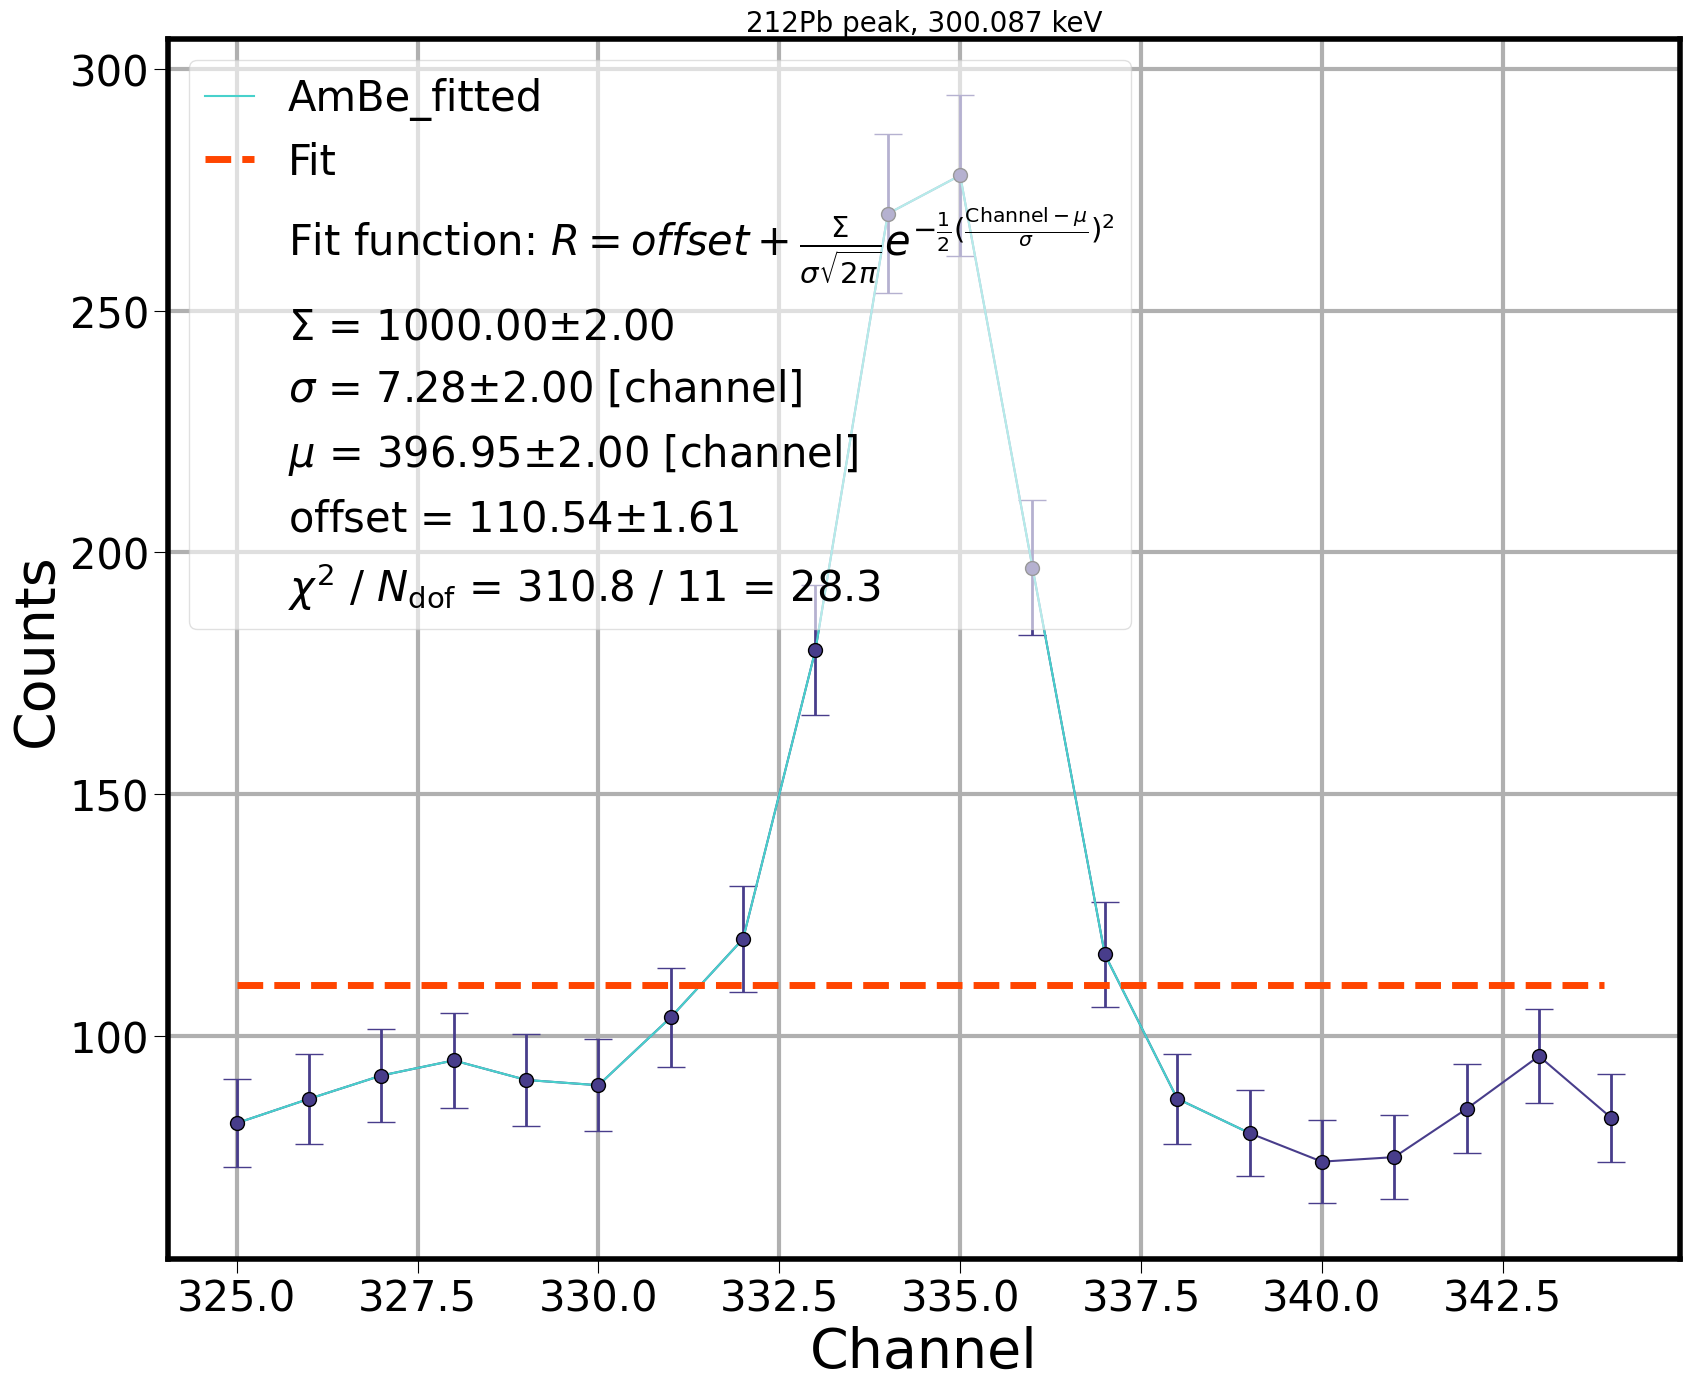

In [10]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()

#plot data with errorbars
#Data_err = ax1.errorbar(scan[0], np.asarray(scan[1])*1e6, 
     #   yerr=np.asarray(scan[num][4])*1e6, fmt='o', mec='black',  mew=1, 
       # color = 'blue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

#on top plot the same data w/o errorbars with nicer markers, give name to add to the legend

ch1=325
ch2=340
ch3=325
ch4=345

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]

Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

handlelist.append(Data)
labellist.append(Data.get_label())

#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 1000
mu00 = 332
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 

#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]


for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 510.69 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1717 (chi2/ndof = 17.9)    │              Nfcn = 245              │
│ EDM = 3.19e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    -50    │    40     │            │            │         │         │       │
│ 1 │ sig    │    8.5    │    2.6    │            │            │         │         │       │
│ 2 │ mu     │    542    │     7     │            │            │         │         │       │
│ 3 │ offset │   29.6    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 1.34e+03    -26.4     6.74    -13.9 │
│    sig │    -26.4     6.48    -3.14    0.263 │
│     mu │     6.74    -3.14     49.1  -0.0669 │
│ offset │    -13.9    0.263  -0.0669    0.435 │
└────────┴─────────────────────────────────────┘

<ValueView A=-47.430539692350074 sig=8.510138578369391 mu=542.0539606114932 offset=29.559083291875016>
<ErrorView A=36.64859810545178 sig=2.54646635138239 mu=7.0039013803896655 offset=0.6592758524899232>
(-47.430539692350074, 8.510138578369391, 542.0539606114932, 29.559083291875016)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa568086748> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa568086748> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

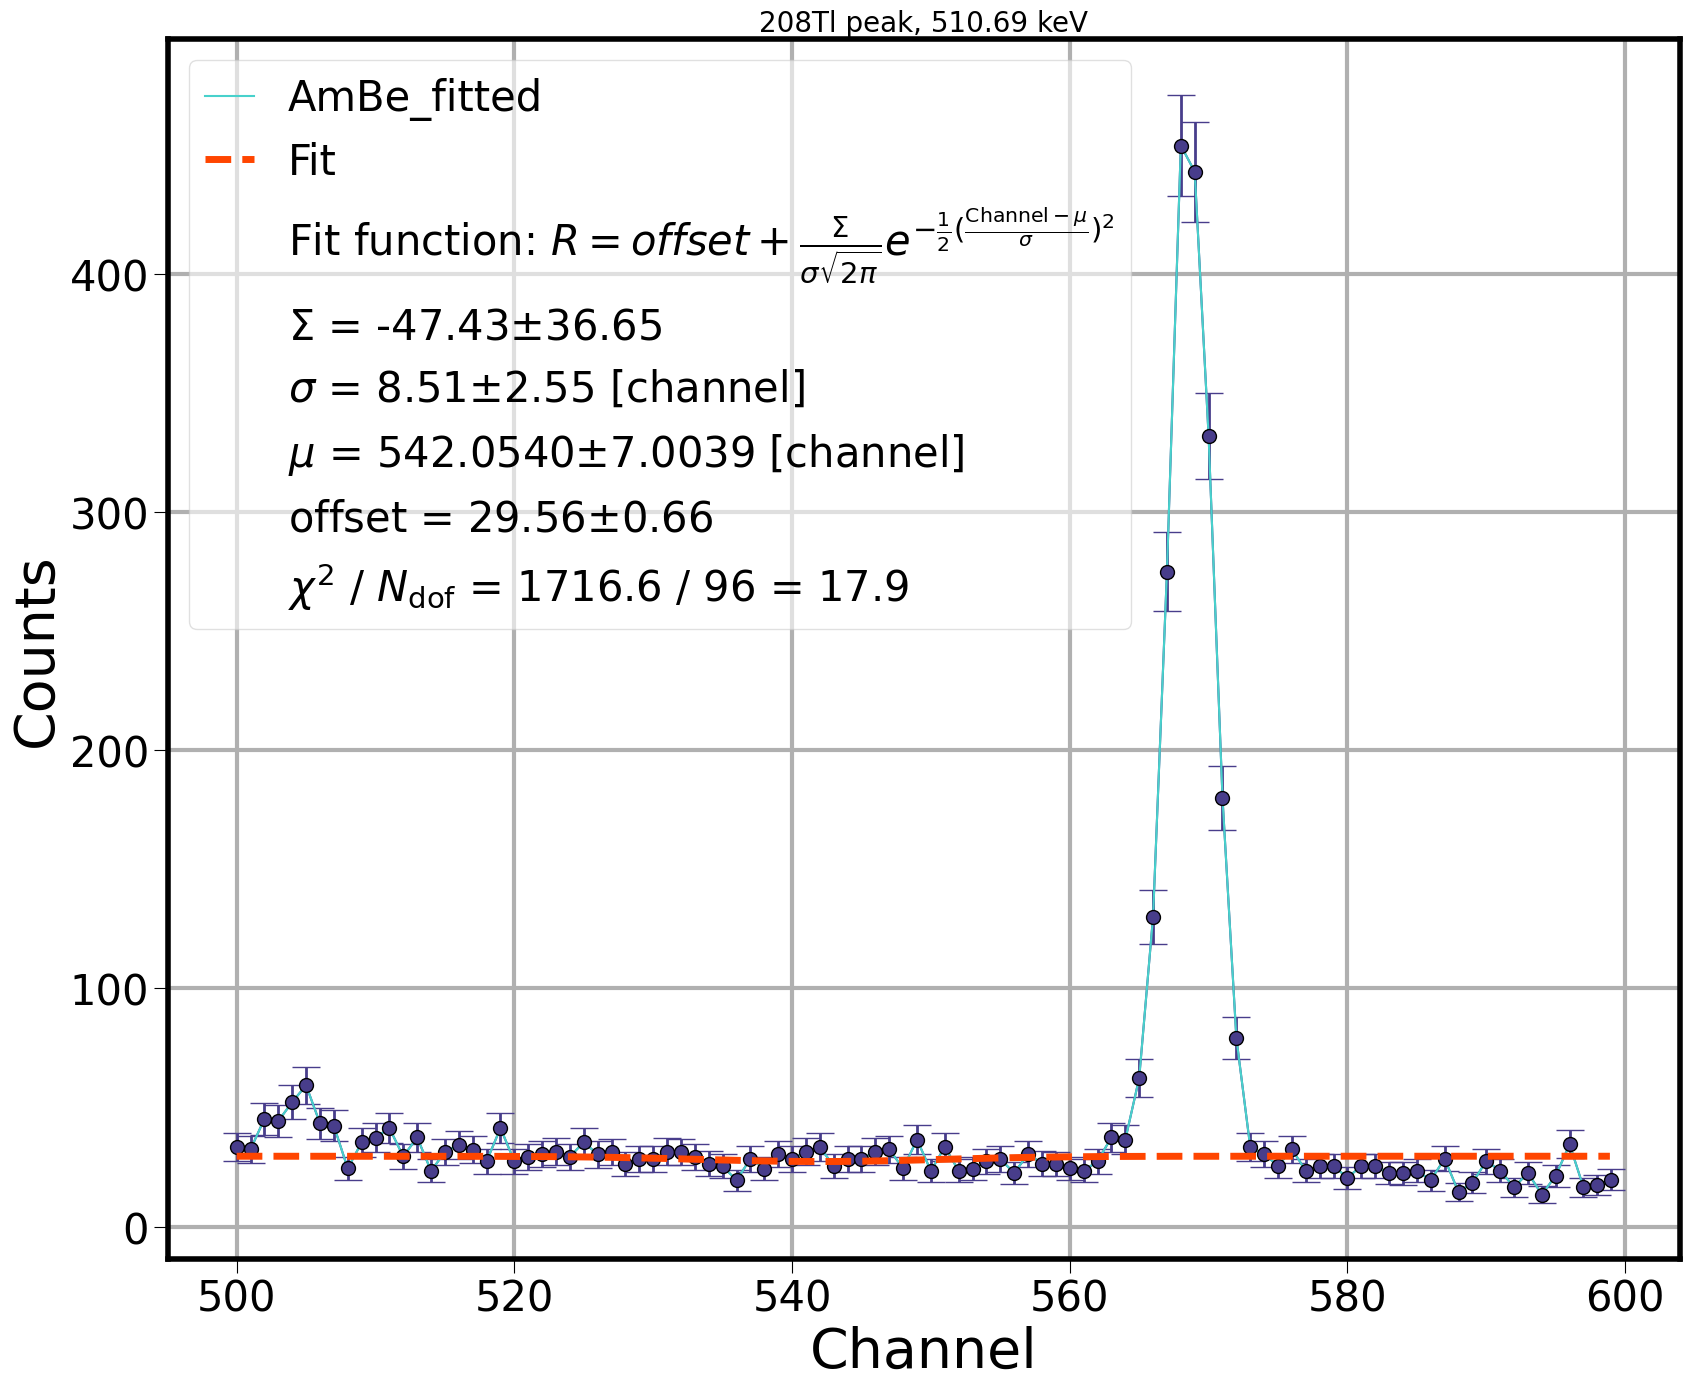

In [11]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()

ch1=500
ch2=600
ch3=500
ch4=600

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())

#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)


#set initial parameter values
A00 = 1000
mu00 = 550
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)

#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]

for string in text:
    handlelist.append(extra)
    labellist.append(string)



fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 583.191 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3669 (chi2/ndof = 38.2)    │              Nfcn = 255              │
│ EDM = 0.000143 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    746    │     7     │            │            │         │         │       │
│ 1 │ sig    │   0.215   │   0.006   │            │            │         │         │       │
│ 2 │ mu     │  648.996  │   0.019   │            │            │         │         │       │
│ 3 │ offset │   16.1    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │      54.5     0.016   -0.0099    -0.388 │
│    sig │     0.016  3.99e-05  1.37e-05 -7.46e-05 │
│     mu │   -0.0099  1.37e-05  0.000353  0.000661 │
│ offset │    -0.388 -7.46e-05  0.000661     0.162 │
└────────┴─────────────────────────────────────────┘

<ValueView A=745.8964270418169 sig=0.21511687673707924 mu=648.9962602492457 offset=16.115093024057558>
<ErrorView A=7.380778654967839 sig=0.006318486936081037 mu=0.018776535777239686 offset=0.40248662375979505>
(745.8964270418169, 0.21511687673707924, 648.9962602492457, 16.115093024057558)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa5690beeb8> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:176: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa5690beeb8> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

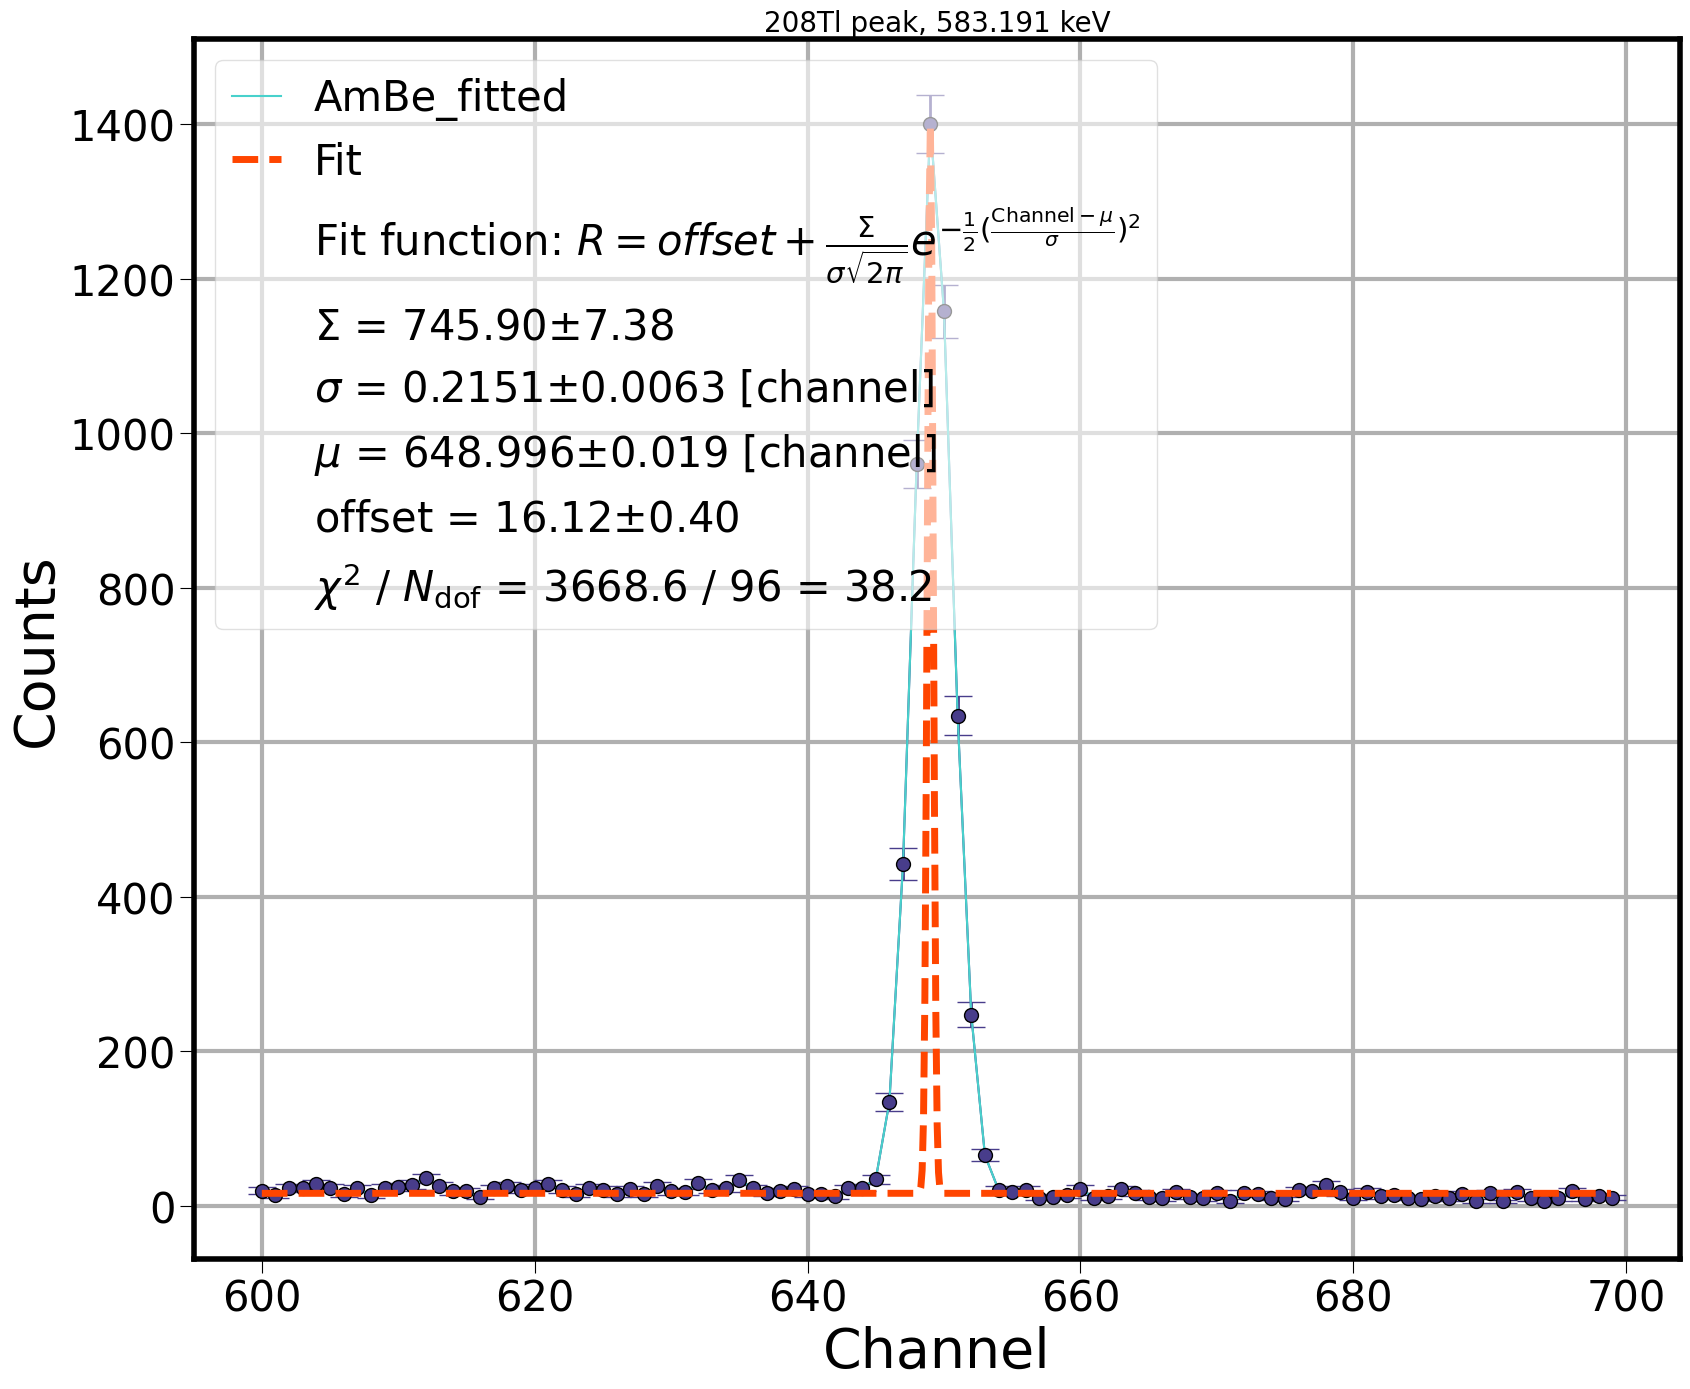

In [12]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=600
ch2=700
ch3=600
ch4=700

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

handlelist.append(Data)
labellist.append(Data.get_label())

#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 1000
mu00 = 645
sig00 = 5 
offset00 = 100

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)


#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)


#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)


fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 727.33 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 52.6 (chi2/ndof = 1.1)     │              Nfcn = 170              │
│ EDM = 0.000127 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    953    │    32     │            │            │         │         │       │
│ 1 │ sig    │   1.47    │   0.04    │            │            │         │         │       │
│ 2 │ mu     │  809.41   │   0.05    │            │            │         │         │       │
│ 3 │ offset │    7.6    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  1.03e+03     0.147   0.00654     -1.64 │
│    sig │     0.147   0.00196  8.83e-05  -0.00294 │
│     mu │   0.00654  8.83e-05   0.00266 -0.000149 │
│ offset │     -1.64  -0.00294 -0.000149     0.185 │
└────────┴─────────────────────────────────────────┘

<ValueView A=953.0771512181631 sig=1.4670640575948781 mu=809.4110129186458 offset=7.633075046131403>
<ErrorView A=32.17108498600944 sig=0.04427930078993817 mu=0.05159703586709612 offset=0.4306381927528278>
(953.0771512181631, 1.4670640575948781, 809.4110129186458, 7.633075046131403)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:143: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56aed3da0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:176: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56aed3da0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

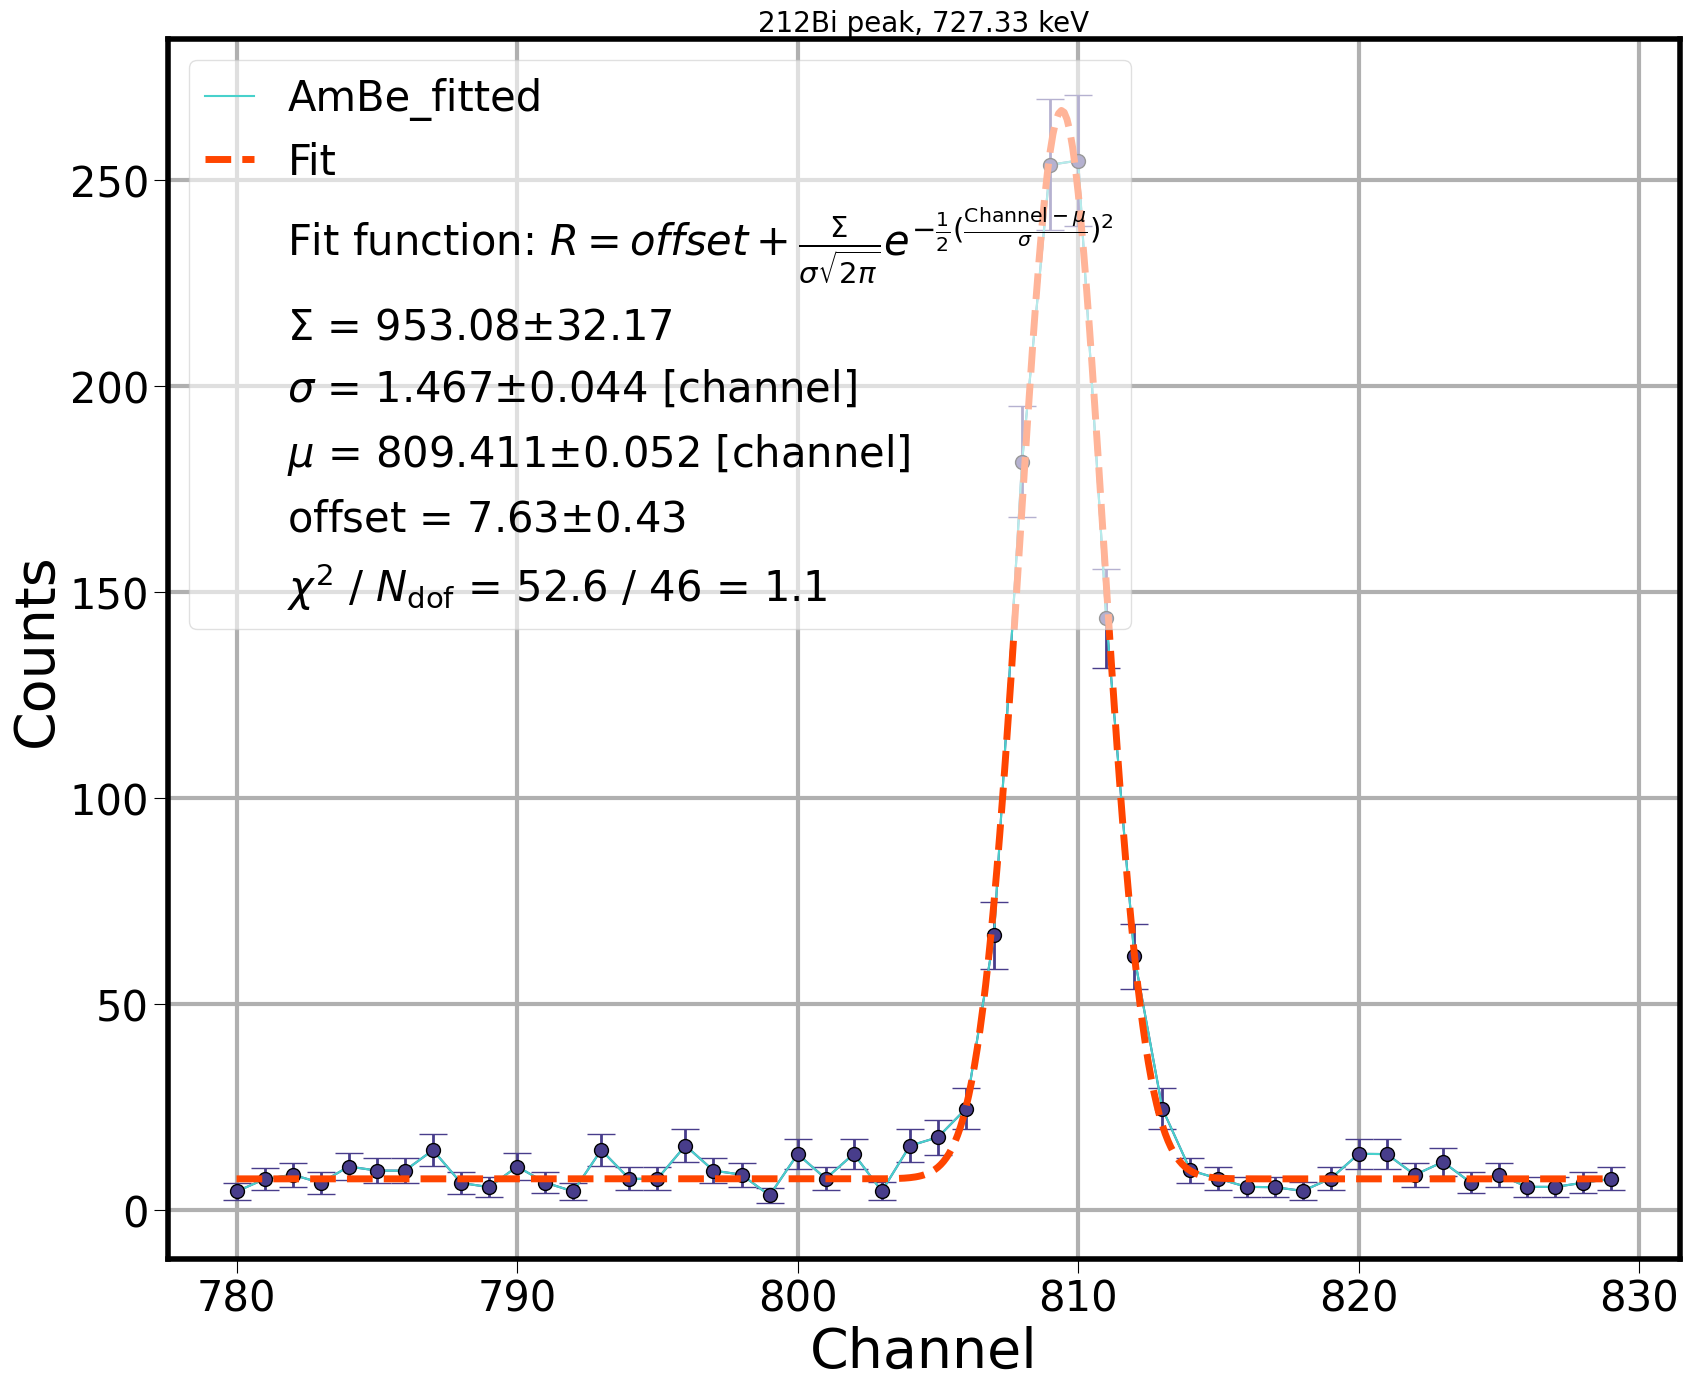

In [13]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()

ch1=780
ch2=830
ch3=780
ch4=830

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]

Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

handlelist.append(Data)
labellist.append(Data.get_label())

#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)


#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)


#set initial parameter values
A00 = 1000
mu00 = 805
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)


#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]


for string in text:
    handlelist.append(extra)
    labellist.append(string)


fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 763.13 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.52 (chi2/ndof = 1.0)    │              Nfcn = 113              │
│ EDM = 6.18e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    93     │    13     │            │            │         │         │       │
│ 1 │ sig    │   1.46    │   0.20    │            │            │         │         │       │
│ 2 │ mu     │  849.68   │   0.23    │            │            │         │         │       │
│ 3 │ offset │    6.1    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │     162   0.914  -0.319    -2.3 │
│    sig │   0.914  0.0407 -0.0183 -0.0304 │
│     mu │  -0.319 -0.0183   0.054  0.0106 │
│ offset │    -2.3 -0.0304  0.0106   0.279 │
└────────┴─────────────────────────────────┘

<ValueView A=92.76432882409208 sig=1.4596170092211278 mu=849.6811902712847 offset=6.063048655884044>
<ErrorView A=12.723250165534616 sig=0.2017879468366429 mu=0.23245973585761545 offset=0.5280855189372421>
(92.76432882409208, 1.4596170092211278, 849.6811902712847, 6.063048655884044)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a54e9b0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:171: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a54e9b0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

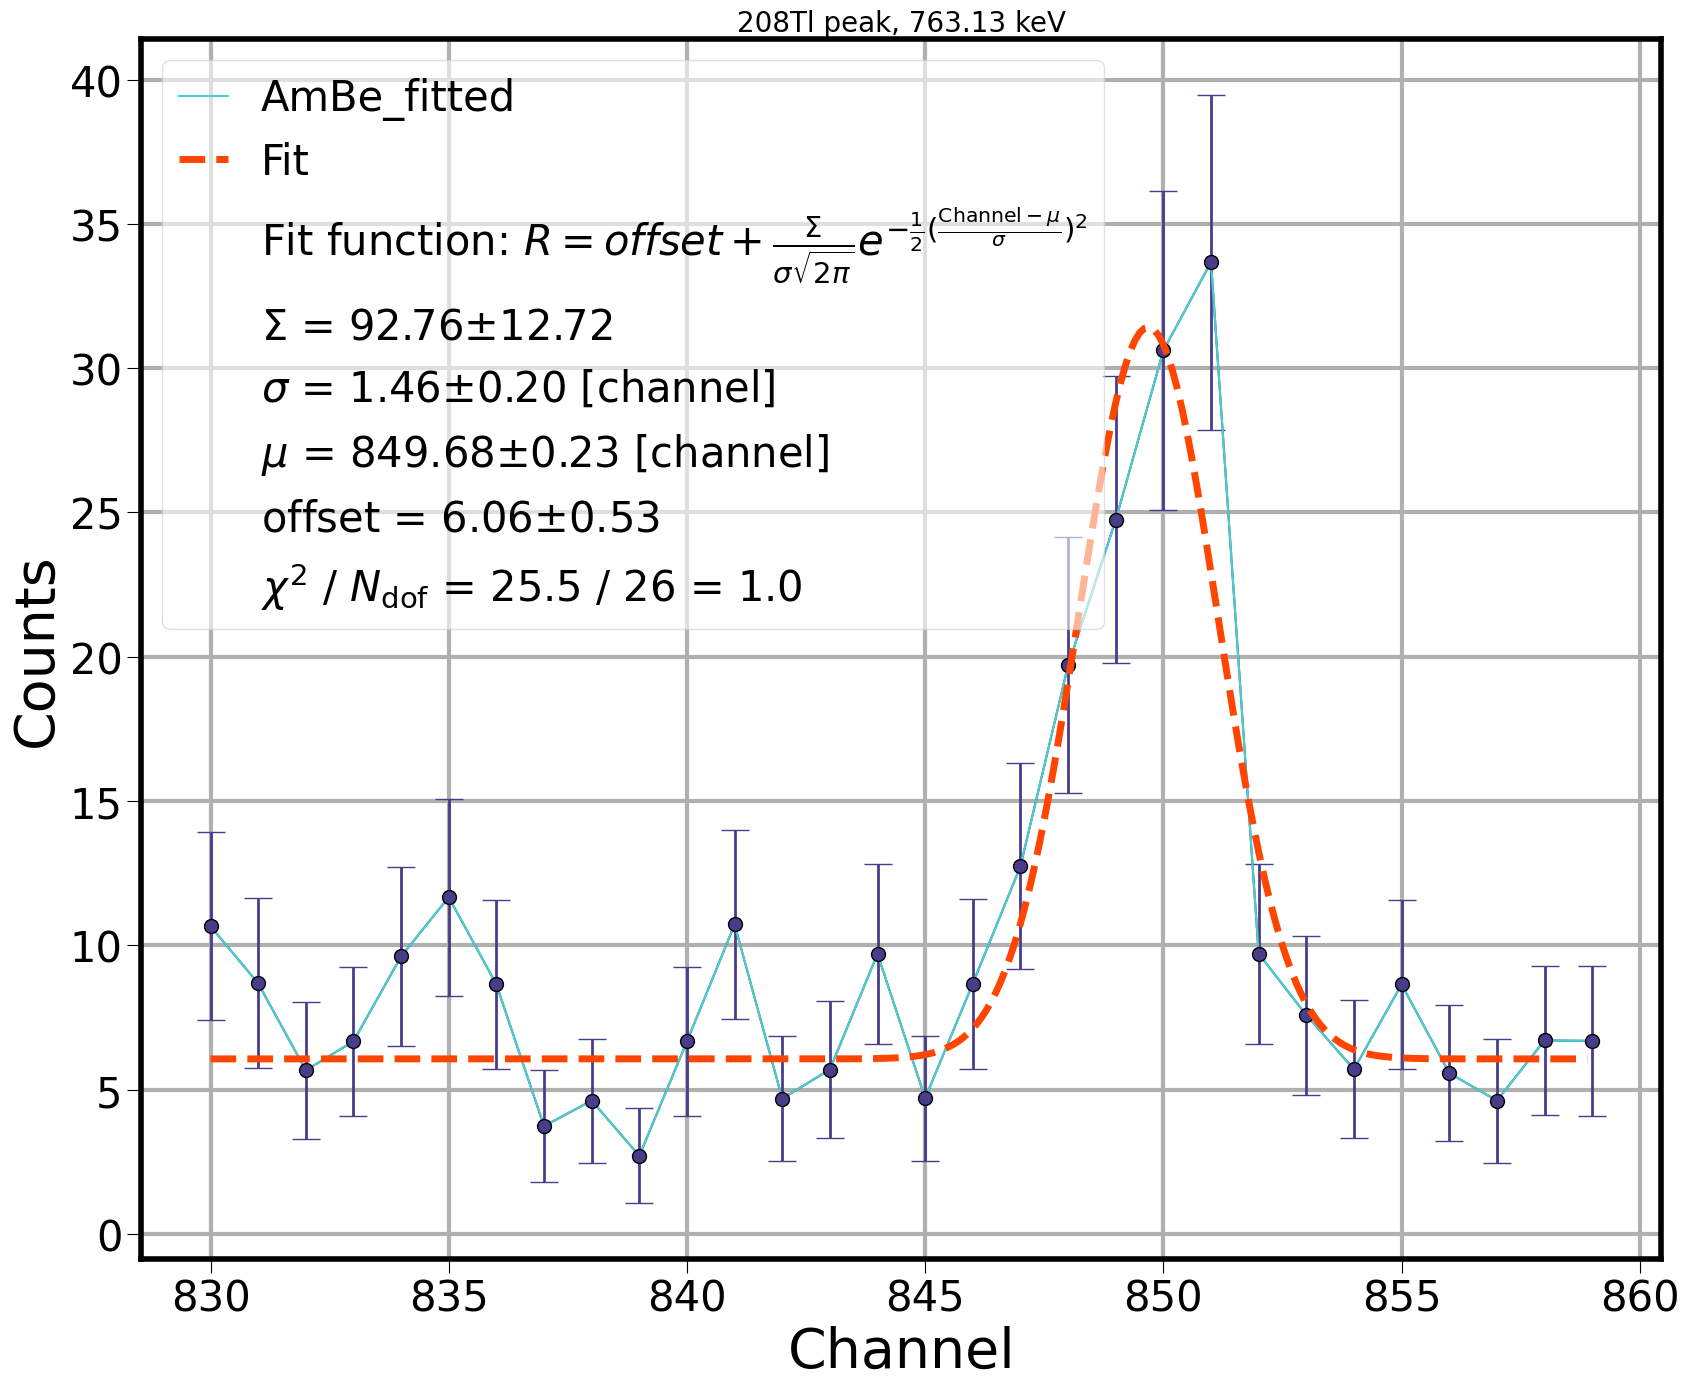

In [14]:
plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)
#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()

ch1=830
ch2=860
ch3=830
ch4=860

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())


#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 200
mu00 = 844
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]

for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 785.37 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 116.3 (chi2/ndof = 7.3)    │              Nfcn = 517              │
│ EDM = 4.62e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │ -0.001e6  │  0.011e6  │            │            │         │         │       │
│ 1 │ sig    │    0.5    │    0.8    │            │            │         │         │       │
│ 2 │ mu     │   880.6   │    1.3    │            │            │         │         │       │
│ 3 │ offset │   10.0    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  1.24e+08  7.42e+03  7.04e+03      -131 │
│    sig │  7.42e+03     0.581     0.853 -0.000474 │
│     mu │  7.04e+03     0.853      1.78   -0.0149 │
│ offset │      -131 -0.000474   -0.0149     0.521 │
└────────┴─────────────────────────────────────────┘

<ValueView A=-1027.3661223082502 sig=0.4706525673779369 mu=880.6210128207414 offset=9.998845741197343>
<ErrorView A=11156.46748070645 sig=0.7622367894129543 mu=1.3335993395858998 offset=0.7218128874851804>
(-1027.3661223082502, 0.4706525673779369, 880.6210128207414, 9.998845741197343)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:133: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa569ac0e48> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa569ac0e48> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

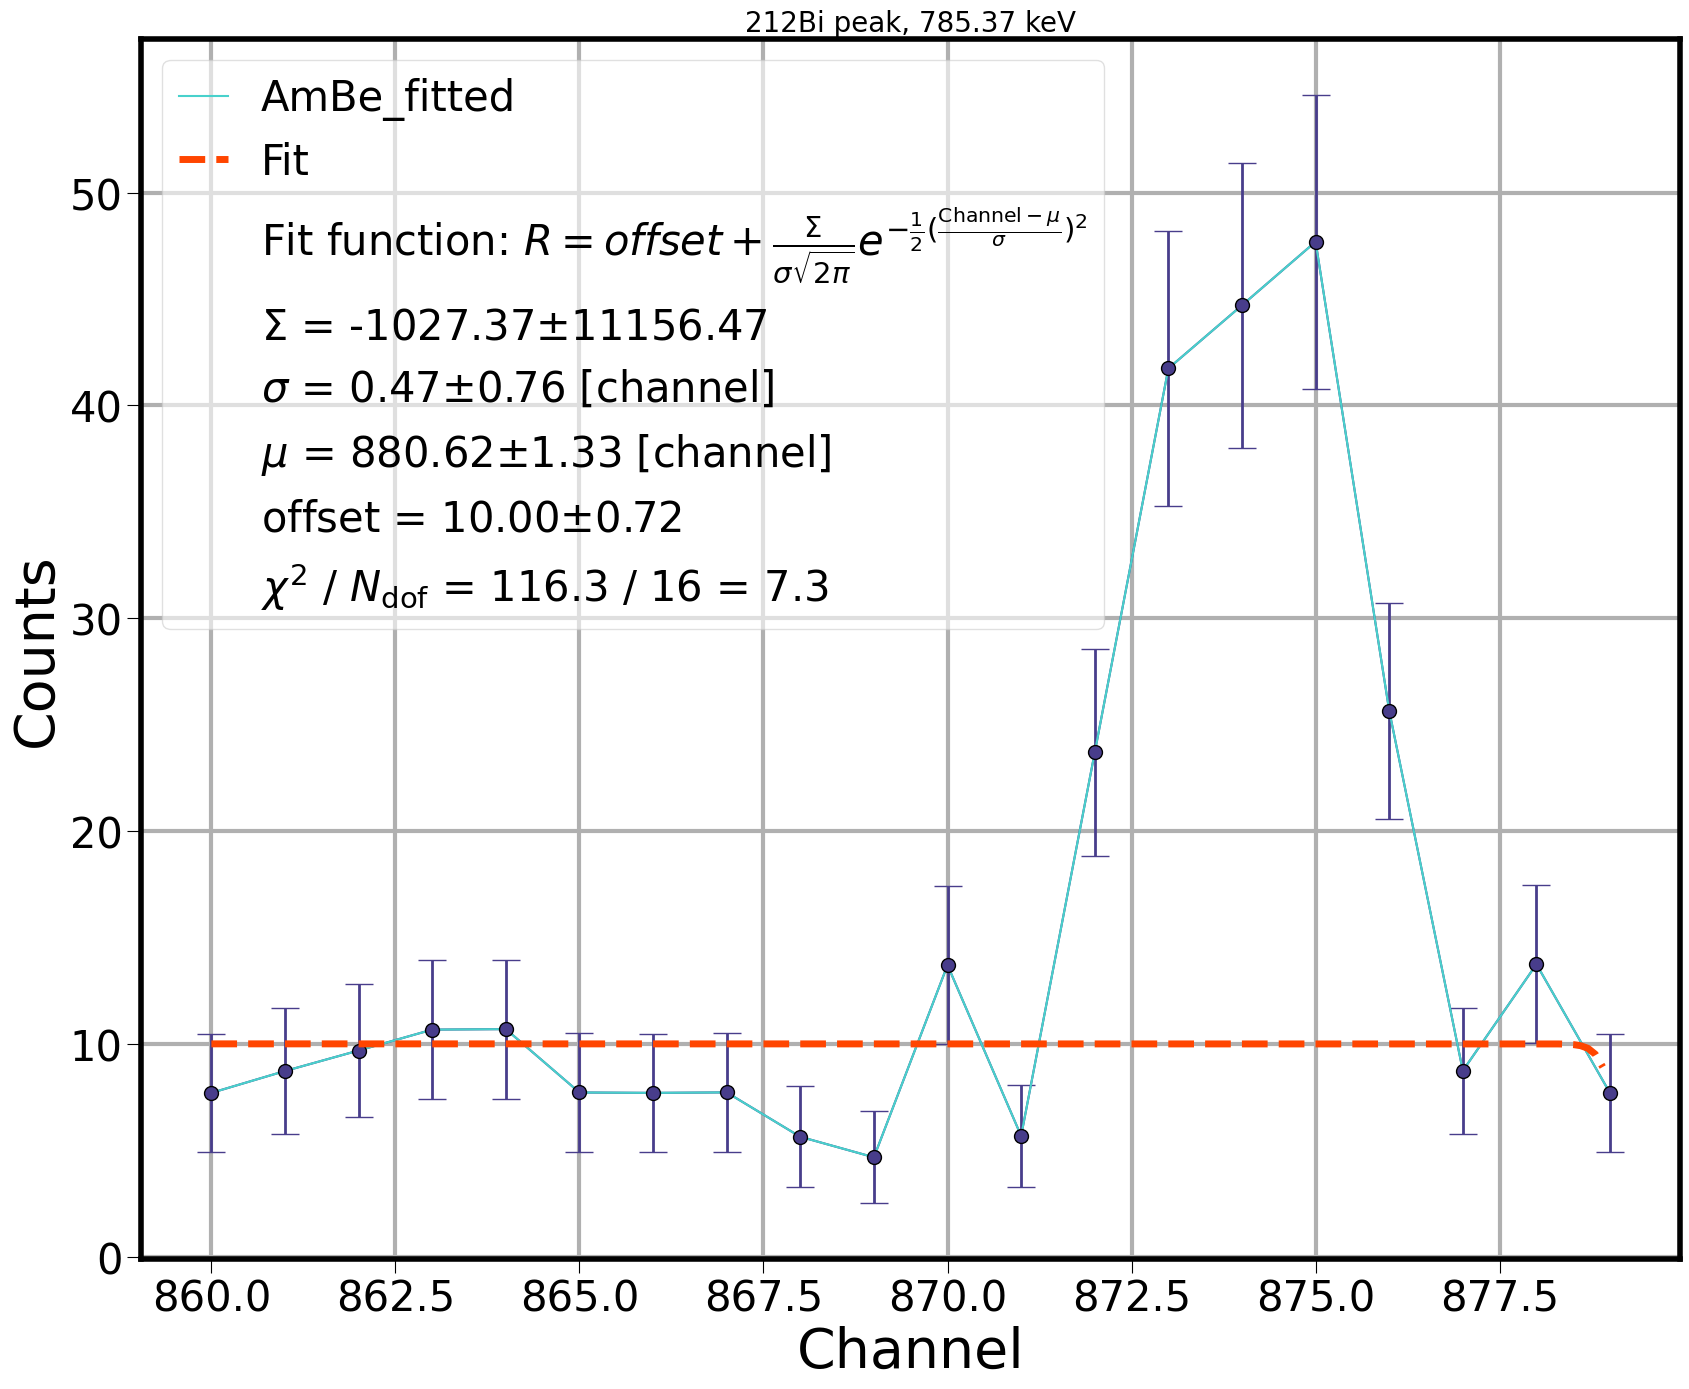

In [15]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=860
ch2=880
ch3=860
ch4=880

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]

Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())


#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)


#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 500
mu00 = 867
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 

#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]


for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 860.564 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 70.56 (chi2/ndof = 2.0)    │              Nfcn = 139              │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    626    │    26     │            │            │         │         │       │
│ 1 │ sig    │   1.61    │   0.05    │            │            │         │         │       │
│ 2 │ mu     │  957.51   │   0.07    │            │            │         │         │       │
│ 3 │ offset │    4.2    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │       683     0.154     0.028     -1.42 │
│    sig │     0.154   0.00277   0.00079  -0.00387 │
│     mu │     0.028   0.00079   0.00516 -0.000723 │
│ offset │     -1.42  -0.00387 -0.000723     0.139 │
└────────┴─────────────────────────────────────────┘

<ValueView A=625.9830835017381 sig=1.6079024891199083 mu=957.5072482886304 offset=4.153423346155103>
<ErrorView A=26.132198761854294 sig=0.05267374347300189 mu=0.07182342771251807 offset=0.3734343224081228>
(625.9830835017381, 1.6079024891199083, 957.5072482886304, 4.153423346155103)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56aec1cf8> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:171: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56aec1cf8> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

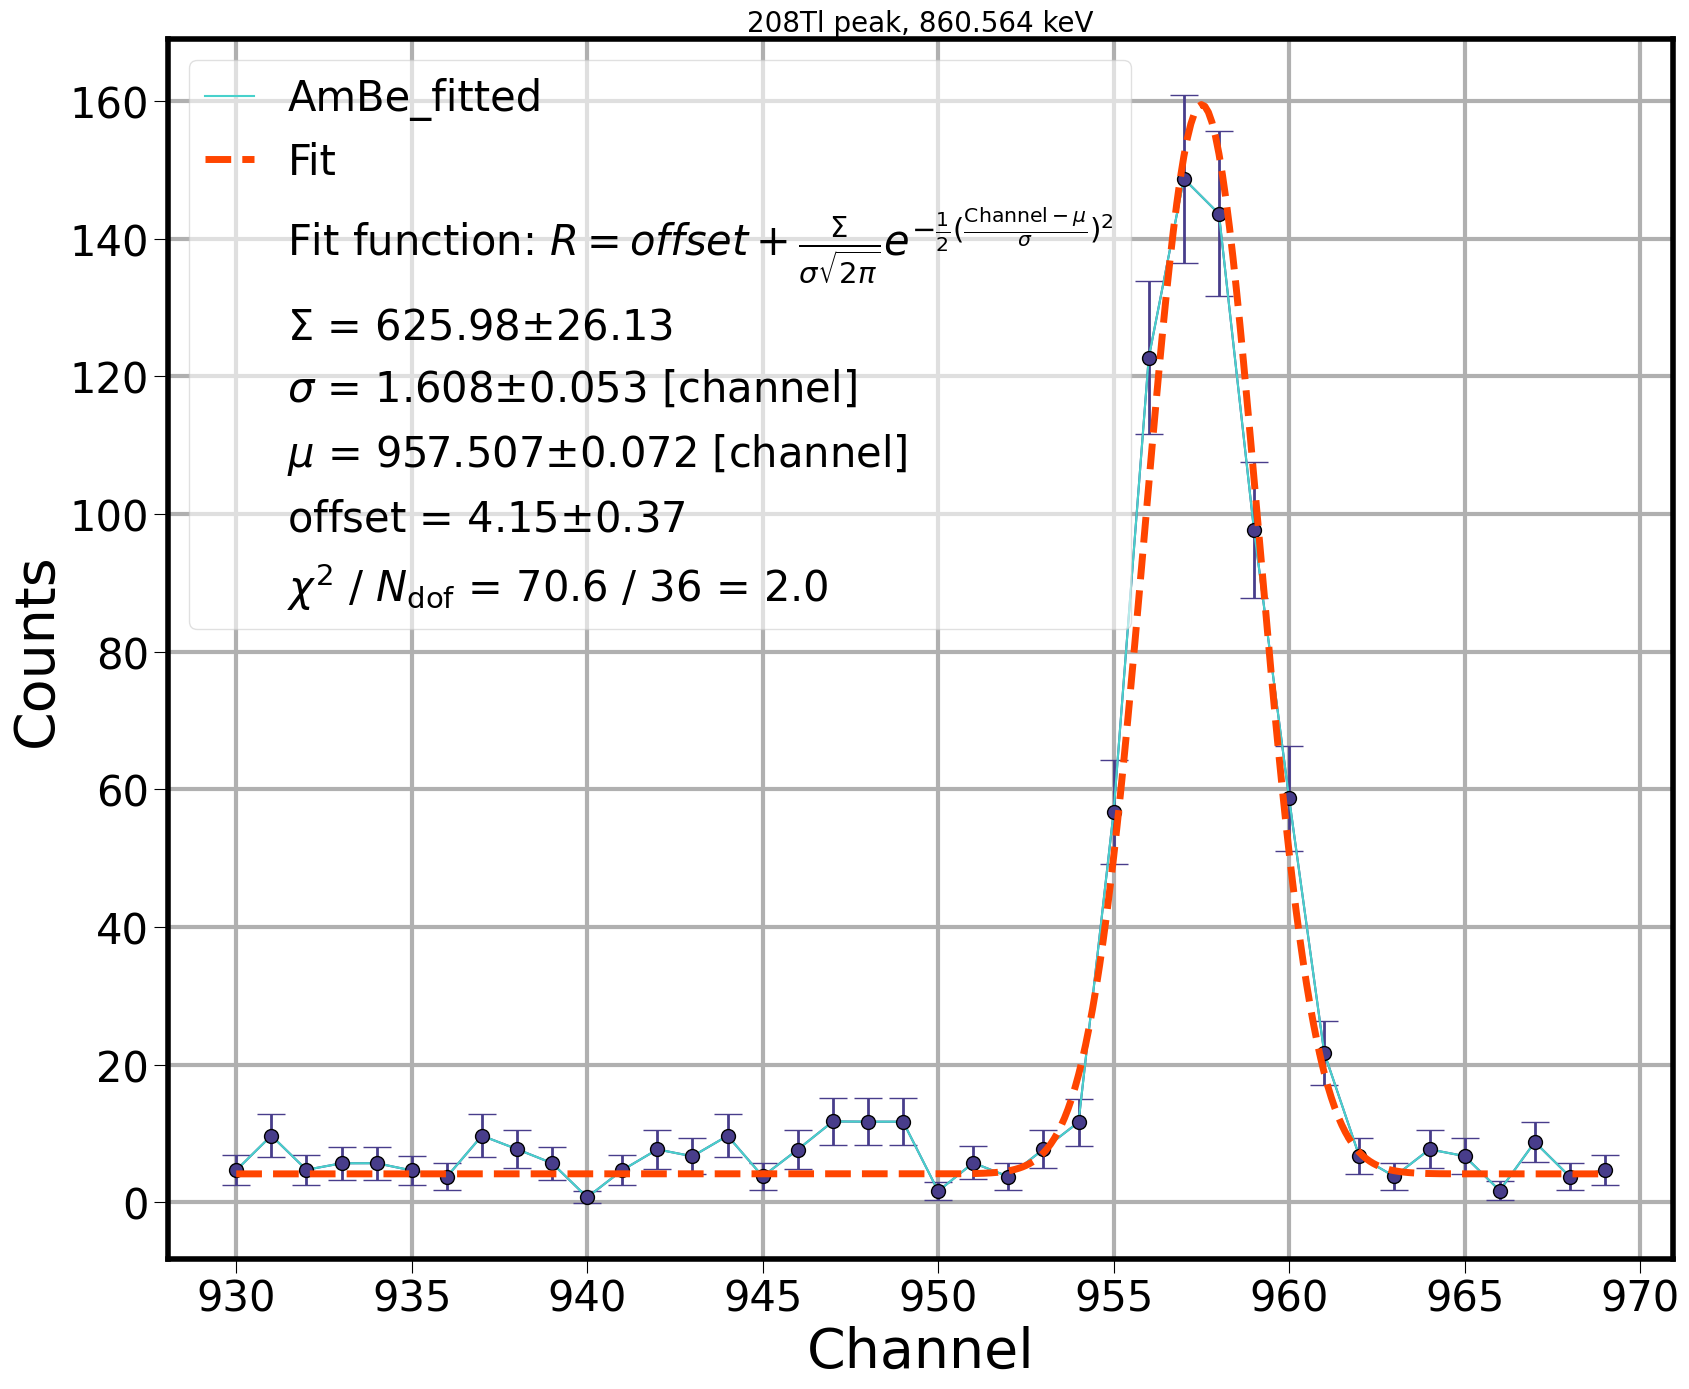

In [16]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)


#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=930
ch2=970
ch3=930
ch4=970

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())


#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)


#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)


#set initial parameter values
A00 = 500
mu00 = 950
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)


#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]

for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 893.408 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 53.35 (chi2/ndof = 2.1)    │              Nfcn = 536              │
│ EDM = 1.55e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  0.01e9   │  0.14e9   │            │            │         │         │       │
│ 1 │ sig    │    0.8    │    0.8    │            │            │         │         │       │
│ 2 │ mu     │ 1.0033e3  │ 0.0019e3  │            │            │         │         │       │
│ 3 │ offset │    5.5    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  1.96e+16 -1.06e+08 -9.79e+07 -2.88e+05 │
│    sig │ -1.06e+08     0.682      1.09  -0.00143 │
│     mu │ -9.79e+07      1.09      3.46   0.00727 │
│ offset │ -2.88e+05  -0.00143   0.00727     0.187 │
└────────┴─────────────────────────────────────────┘

<ValueView A=6242689.717056069 sig=0.7971624724005202 mu=1003.3248106124896 offset=5.493855071614625>
<ErrorView A=140169383.1282377 sig=0.8260134837190231 mu=1.8591953939573145 offset=0.4319558836697735>
(6242689.717056069, 0.7971624724005202, 1003.3248106124896, 5.493855071614625)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a4070f0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a4070f0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

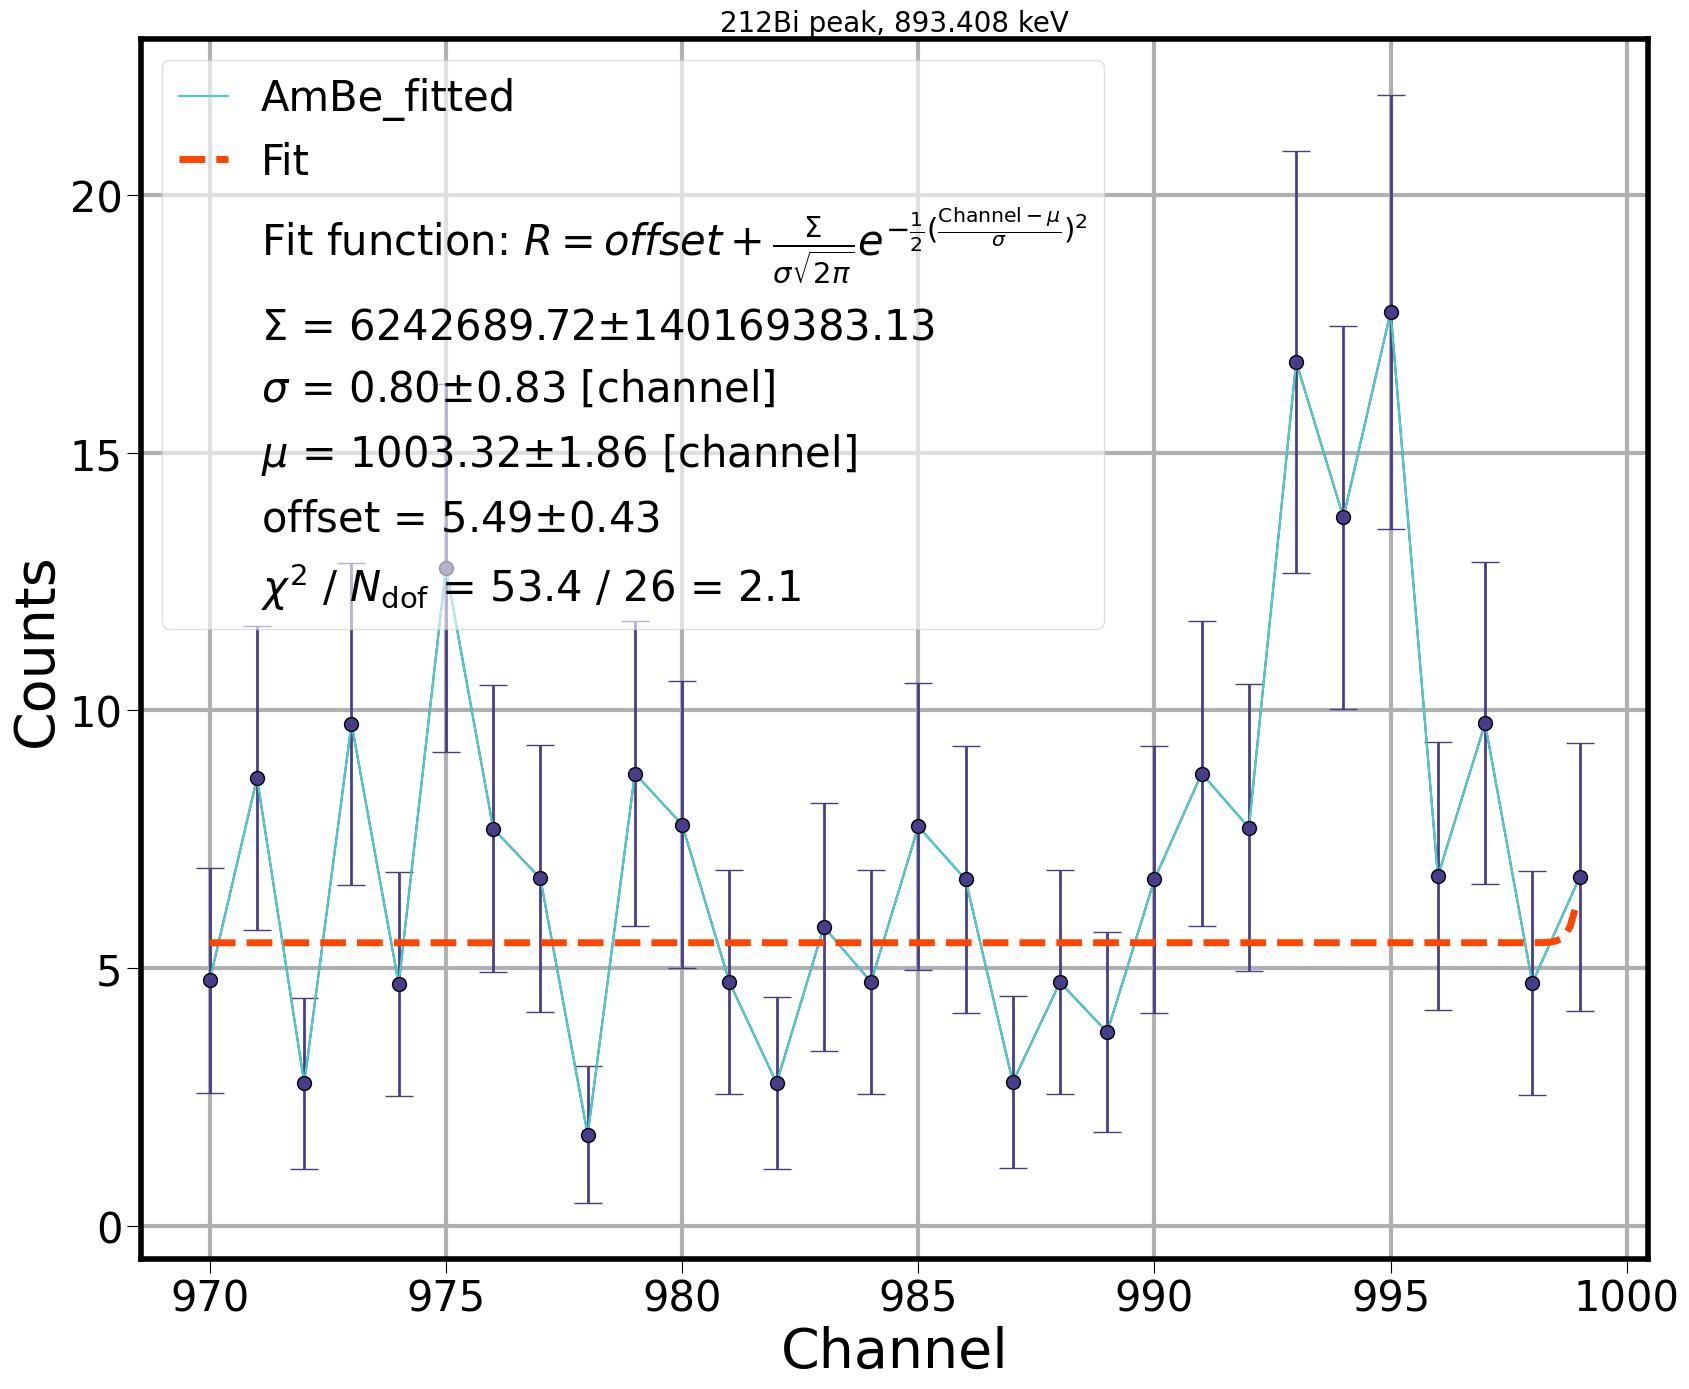

In [17]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)


#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=970
ch2=1000
ch3=970
ch4=1000

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())


#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)



#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)

#set initial parameter values
A00 = 500
mu00 = 990
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 

#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]


for string in text:
    handlelist.append(extra)
    labellist.append(string)

fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1078.62 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.94 (chi2/ndof = 1.5)    │              Nfcn = 346              │
│ EDM = 2.39e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    73     │    11     │            │            │         │         │       │
│ 1 │ sig    │   1.61    │   0.19    │            │            │         │         │       │
│ 2 │ mu     │ 1.19982e3 │ 0.00026e3 │            │            │         │         │       │
│ 3 │ offset │    2.9    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │      115    0.644    0.114    -1.64 │
│    sig │    0.644   0.0372   0.0129  -0.0246 │
│     mu │    0.114   0.0129   0.0688 -0.00358 │
│ offset │    -1.64  -0.0246 -0.00358    0.181 │
└────────┴─────────────────────────────────────┘

<ValueView A=73.14870900344177 sig=1.6129313286879 mu=1199.8164089082888 offset=2.9140073438646885>
<ErrorView A=10.708950673620885 sig=0.19298662210162223 mu=0.2623485903939195 offset=0.4257304601788023>
(73.14870900344177, 1.6129313286879, 1199.8164089082888, 2.9140073438646885)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa569112e48> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:176: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa569112e48> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

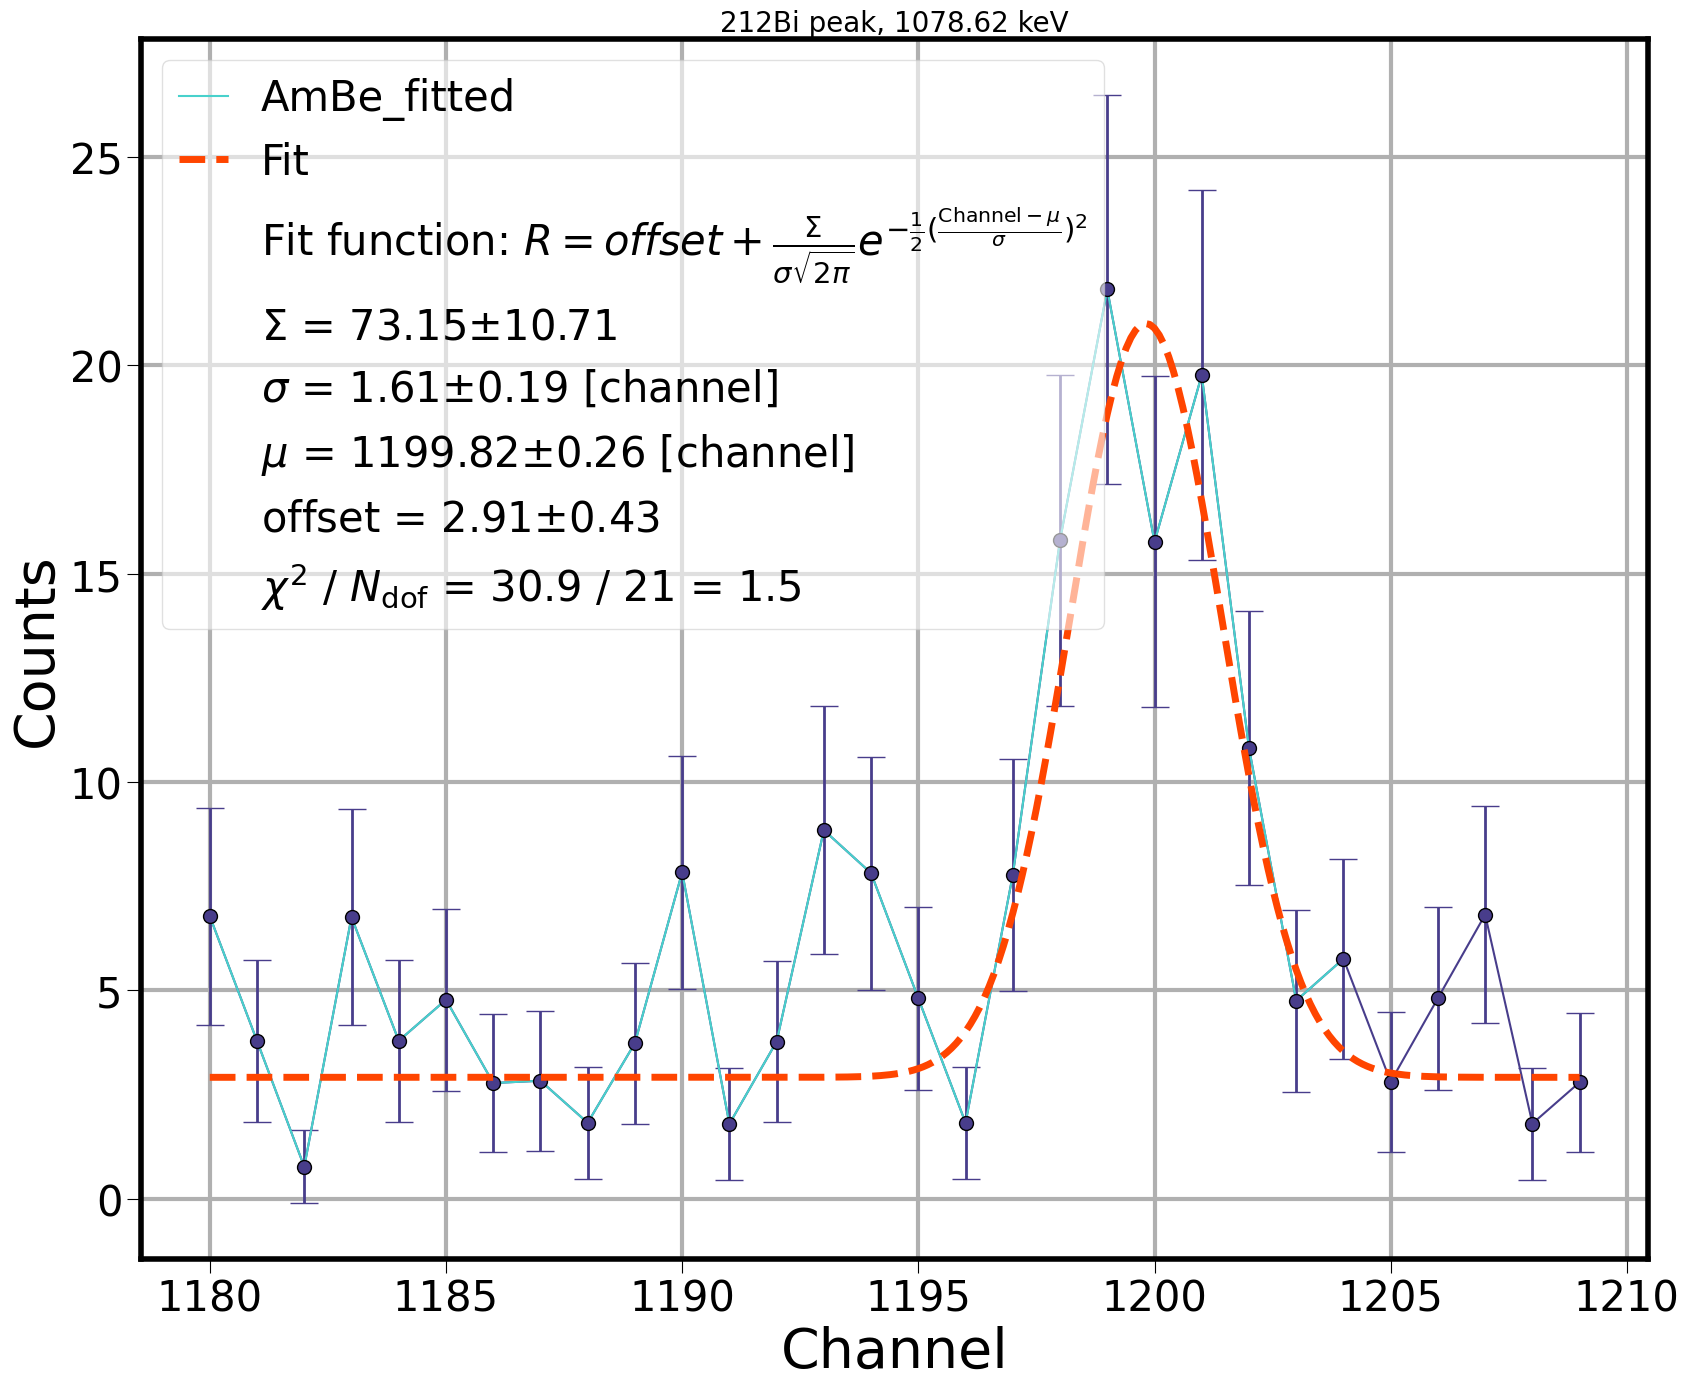

In [18]:


plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1180
ch2=1205
ch3=1180
ch4=1210

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])

handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())


#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)

#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)


#set initial parameter values
A00 = 500
mu00 = 1200
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)


#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)



fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1093.9 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.6 (chi2/ndof = 1.5)     │              Nfcn = 292              │
│ EDM = 4.38e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    17     │     9     │            │            │         │         │       │
│ 1 │ sig    │    2.3    │    1.0    │            │            │         │         │       │
│ 2 │ mu     │ 1.2156e3  │ 0.0013e3  │            │            │         │         │       │
│ 3 │ offset │    4.0    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │    87.5    4.76   0.974   -2.35 │
│    sig │    4.76    1.06   0.234  -0.159 │
│     mu │   0.974   0.234    1.72 -0.0324 │
│ offset │   -2.35  -0.159 -0.0324   0.213 │
└────────┴─────────────────────────────────┘

<ValueView A=17.077950423736265 sig=2.3014883910074793 mu=1215.5925682710663 offset=4.038393861558776>
<ErrorView A=9.355357630802981 sig=1.0288476185260222 mu=1.3103127641175614 offset=0.4614747784050533>
(17.077950423736265, 2.3014883910074793, 1215.5925682710663, 4.038393861558776)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:159: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa5690c2588> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:202: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa5690c2588> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

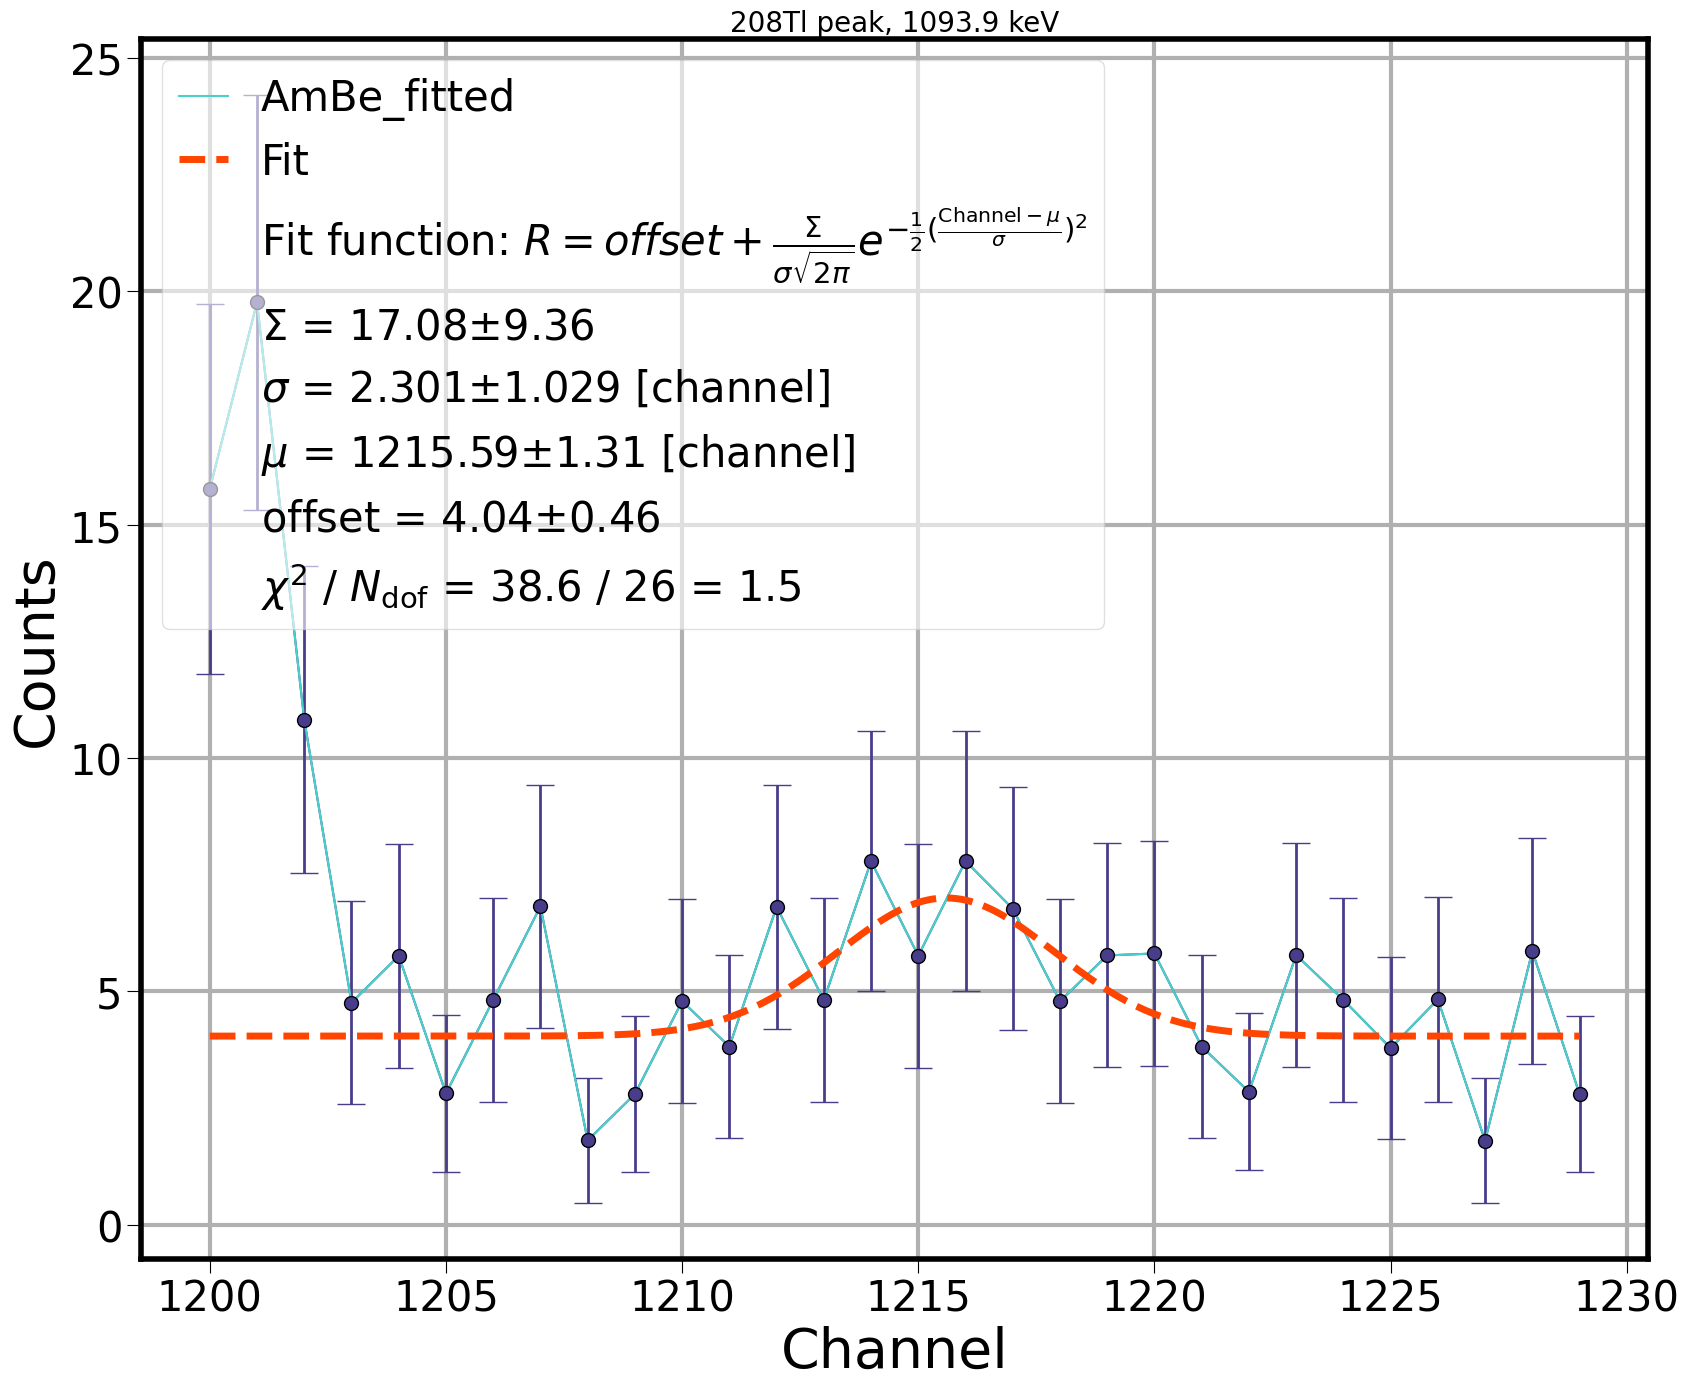

In [19]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1200
ch2=1230
ch3=1200
ch4=1230

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1210
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1512.7 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.03 (chi2/ndof = 1.0)    │              Nfcn = 238              │
│ EDM = 8.88e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    99     │    11     │            │            │         │         │       │
│ 1 │ sig    │   1.63    │   0.21    │            │            │         │         │       │
│ 2 │ mu     │ 1.62472e3 │ 0.00023e3 │            │            │         │         │       │
│ 3 │ offset │   2.24    │   0.24    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │     126   0.503  -0.207  -0.535 │
│    sig │   0.503  0.0429 -0.0254 -0.0101 │
│     mu │  -0.207 -0.0254  0.0535 0.00414 │
│ offset │  -0.535 -0.0101 0.00414  0.0556 │
└────────┴─────────────────────────────────┘

<ValueView A=99.17692191426656 sig=1.6273857940516259 mu=1624.715167567177 offset=2.2442944566428724>
<ErrorView A=11.220701165599602 sig=0.20723962608975416 mu=0.2312738344241151 offset=0.23579281703993954>
(99.17692191426656, 1.6273857940516259, 1624.715167567177, 2.2442944566428724)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:159: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56aec11d0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:202: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56aec11d0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

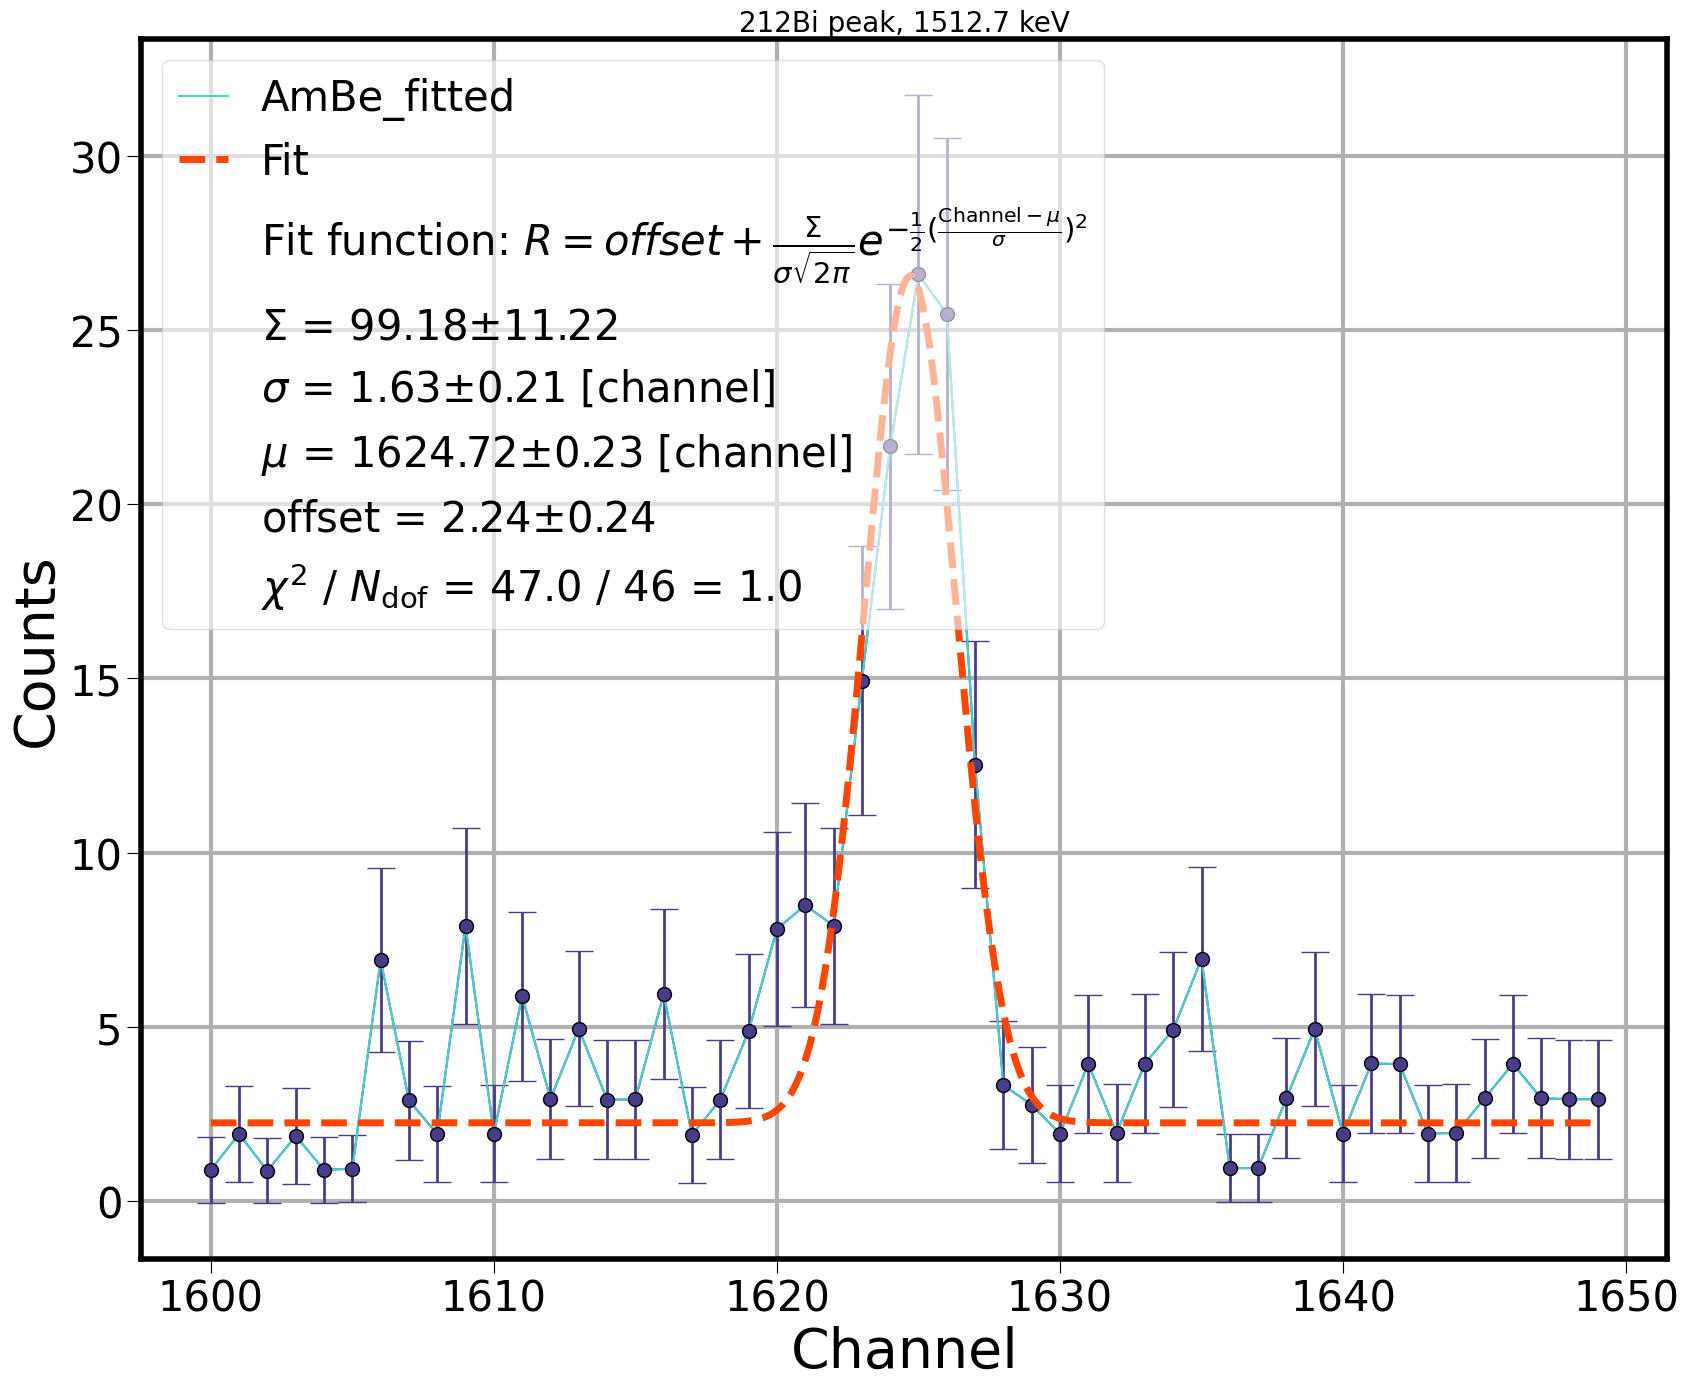

In [20]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1600
ch2=1650
ch3=1600
ch4=1650

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1620
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1592.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

[ 1.9453894   2.94083852  3.92718587  1.94994029  1.96814382  2.95449117
  1.9453894  -0.04550883  4.95904205  1.95904205  6.95449117  4.94083852
  2.95449117  3.94994029  4.9726947   0.94994029  2.92718587  0.89532969
  2.93628764  0.94994029  2.94083852  3.92718587  3.95449117  0.93628764
  0.91808411  4.89077881  0.82706645  4.89988058  9.87257528 24.87257528
 24.90443146 11.94083852 13.9453894  11.9453894   3.93173676  2.93173676
  3.93628764  4.94994029  2.94083852  5.93173676]


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 81.27 (chi2/ndof = 2.3)    │              Nfcn = 340              │
│ EDM = 7.55e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    92     │    10     │            │            │         │         │       │
│ 1 │ sig    │   1.96    │   0.21    │            │            │         │         │       │
│ 2 │ mu     │ 1.77042e3 │ 0.00028e3 │            │            │         │         │       │
│ 3 │ offset │   0.76    │   0.17    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │      105    0.301    0.142   -0.343 │
│    sig │    0.301   0.0445   0.0335  -0.0079 │
│     mu │    0.142   0.0335   0.0769 -0.00379 │
│ offset │   -0.343  -0.0079 -0.00379   0.0291 │
└────────┴─────────────────────────────────────┘

<ValueView A=92.15596834417472 sig=1.9562079970477007 mu=1770.4206482048398 offset=0.7634960021388721>
<ErrorView A=10.257577805181697 sig=0.21084732368031545 mu=0.27733687878601737 offset=0.17055118416163056>
(92.15596834417472, 1.9562079970477007, 1770.4206482048398, 0.7634960021388721)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a602a58> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:172: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56a602a58> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

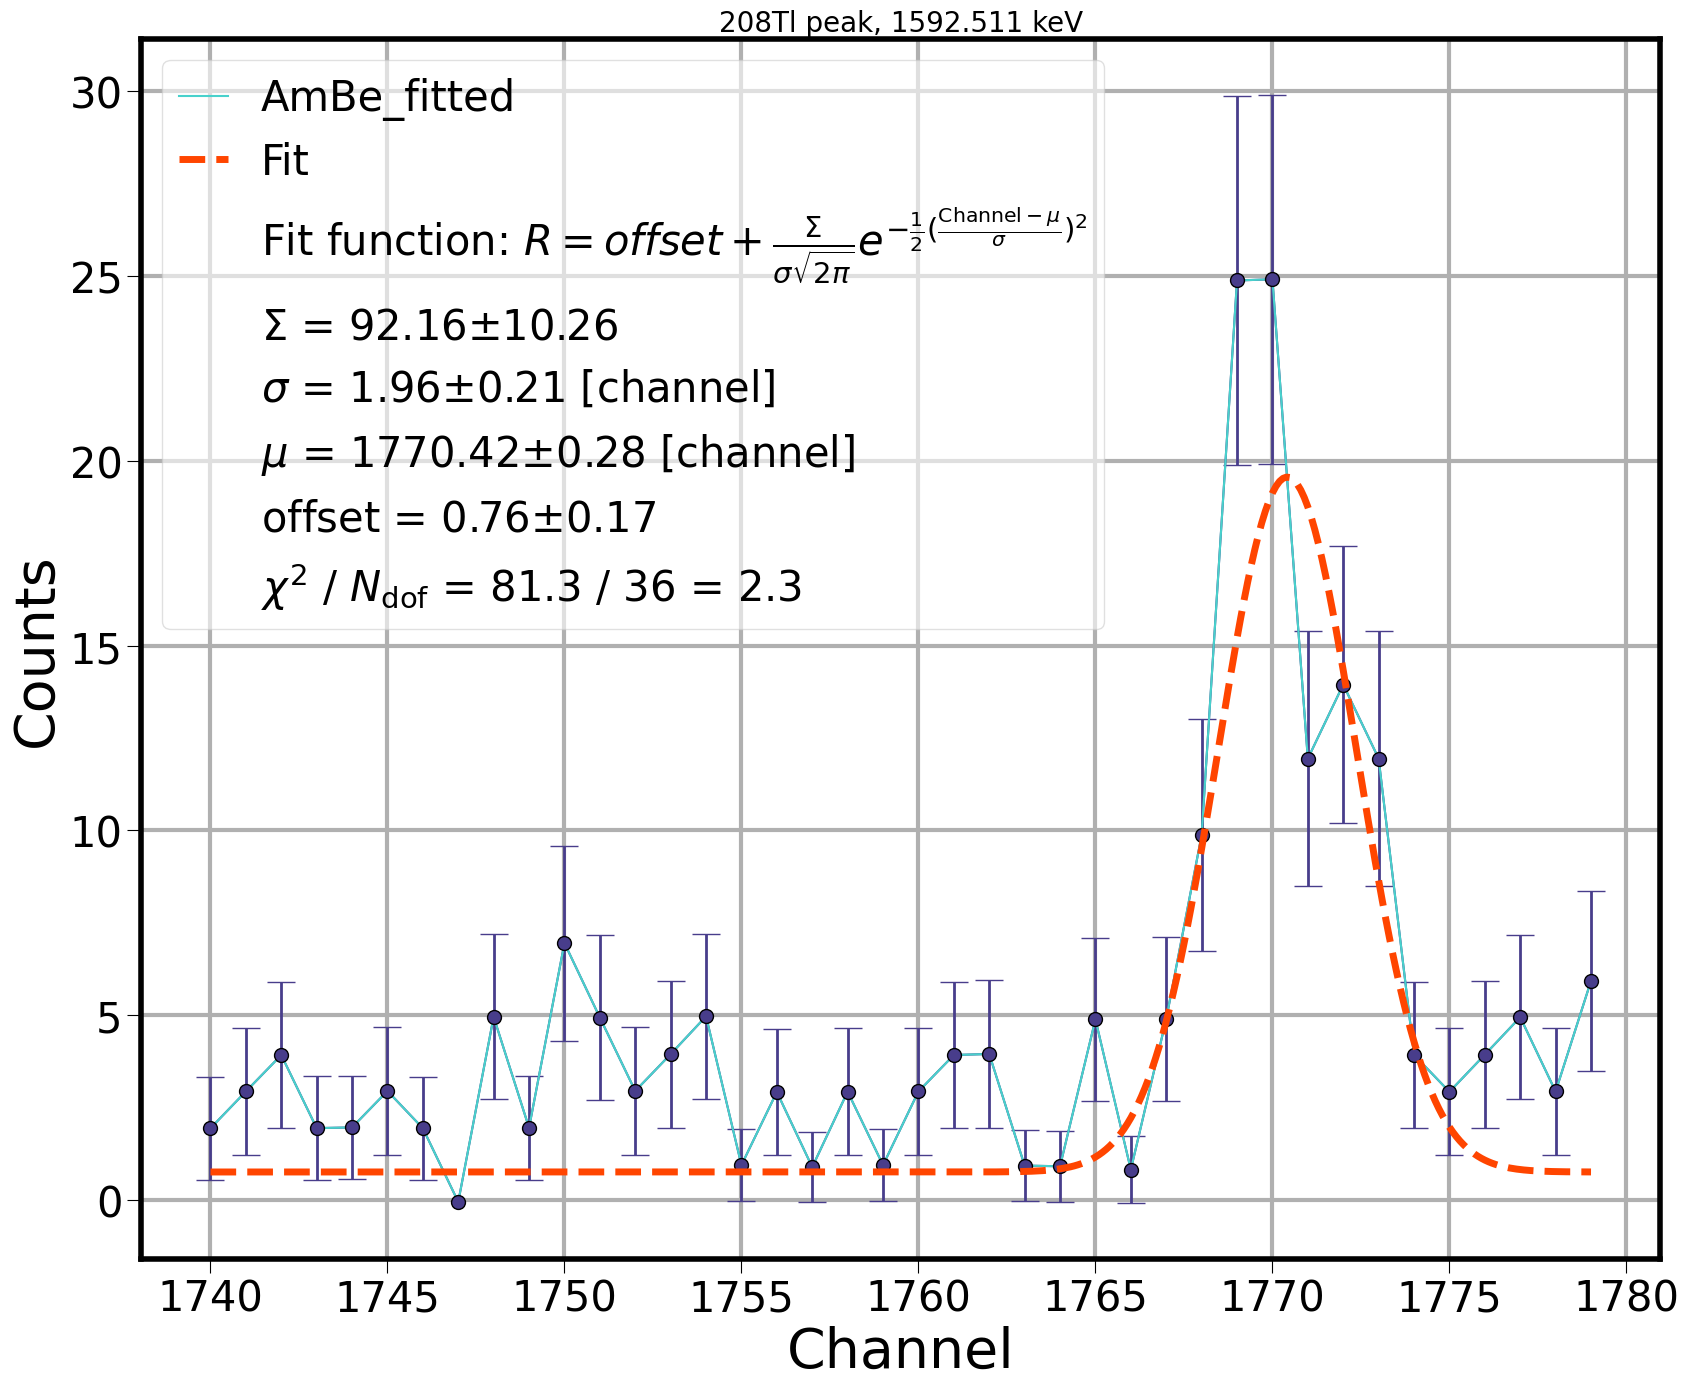

here


In [21]:
plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()

ch1=1740
ch2=1780
ch3=1740
ch4=1780



print(signal[ch1:ch2])


channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
#rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])
rate_no_bkg_err_to_fit=np.sqrt(np.abs(signal[ch1:ch2]))

handlelist=[]
labellist=[]

Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

handlelist.append(Data)
labellist.append(Data.get_label())


#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)


#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)


#set initial parameter values
A00 = 500
mu00 = 1760
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)


#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]


for string in text:
    handlelist.append(extra)
    labellist.append(string)


fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()


print("here")
Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1620.5 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 135 (chi2/ndof = 5.2)      │              Nfcn = 238              │
│ EDM = 2.69e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │ -0.002e6  │  0.010e6  │            │            │         │         │       │
│ 1 │ sig    │    2.0    │    1.4    │            │            │         │         │       │
│ 2 │ mu     │ 1.8153e3  │ 0.0029e3  │            │            │         │         │       │
│ 3 │ offset │    5.0    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 1.07e+08 1.04e+04 1.46e+03      322 │
│    sig │ 1.04e+04     2.06     3.15   0.0629 │
│     mu │ 1.46e+03     3.15     8.69   0.0562 │
│ offset │      322   0.0629   0.0562    0.175 │
└────────┴─────────────────────────────────────┘

<ValueView A=-2322.614896697213 sig=1.973149442834433 mu=1815.264960841929 offset=4.969216845799153>
<ErrorView A=10326.968524660853 sig=1.435471869361196 mu=2.947981360679876 offset=0.4180741875055226>
(-2322.614896697213, 1.973149442834433, 1815.264960841929, 4.969216845799153)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:159: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa569173828> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:202: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa569173828> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

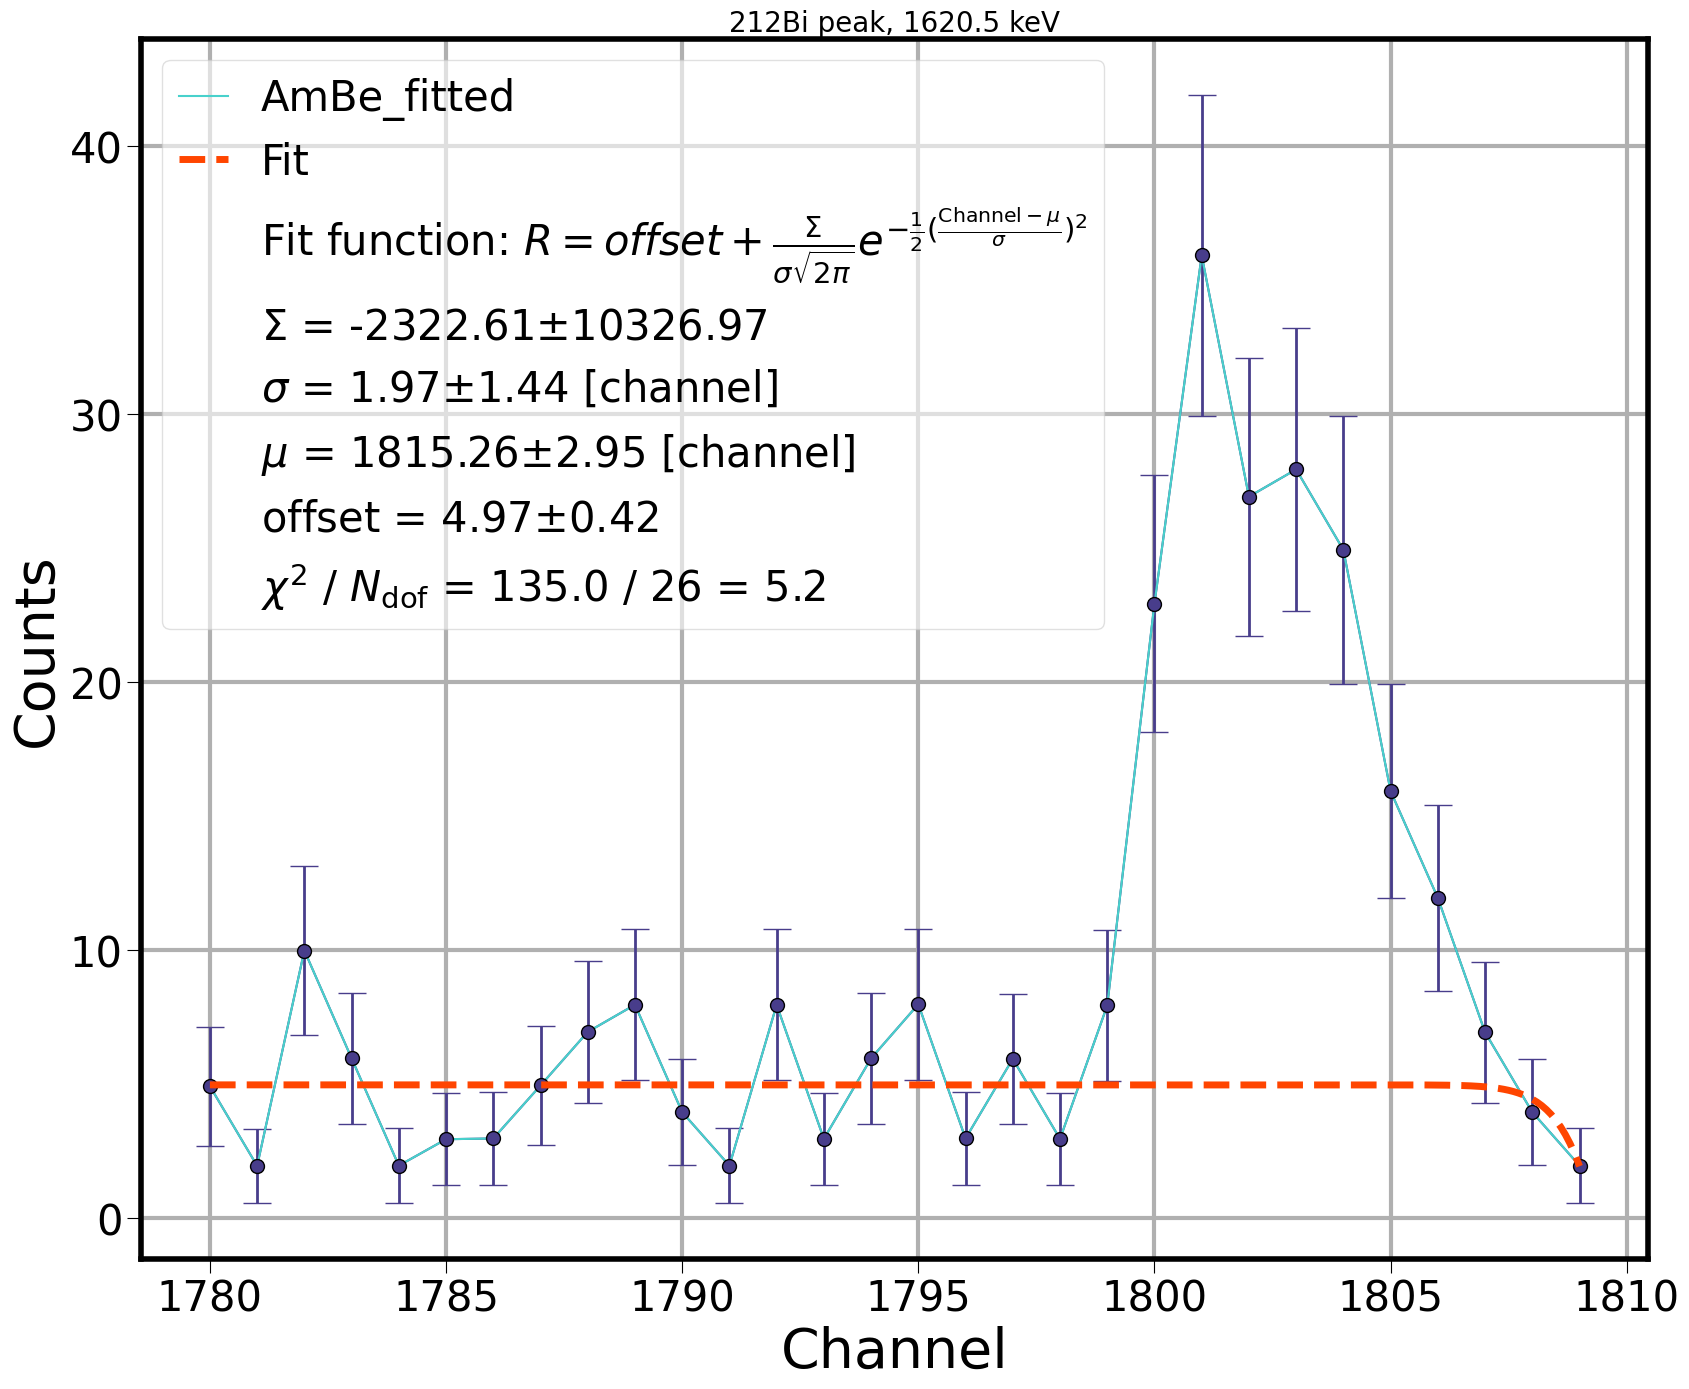

In [22]:

plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1780
ch2=1810
ch3=1780
ch4=1810

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1790
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl SE peak, 2103.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 66.52 (chi2/ndof = 1.4)    │              Nfcn = 423              │
│ EDM = 1.66e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    283    │    19     │            │            │         │         │       │
│ 1 │ sig    │   2.69    │   0.19    │            │            │         │         │       │
│ 2 │ mu     │ 2.33810e3 │ 0.00018e3 │            │            │         │         │       │
│ 3 │ offset │    3.1    │    0.3    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │       354     0.754   -0.0122     -1.41 │
│    sig │     0.754    0.0358 -0.000457   -0.0151 │
│     mu │   -0.0122 -0.000457    0.0343  0.000225 │
│ offset │     -1.41   -0.0151  0.000225    0.0902 │
└────────┴─────────────────────────────────────────┘

/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:160: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56af572b0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:203: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa56af572b0> has a label of '_child0' which cannot be automatically added to the legend.


<ValueView A=283.3297300573396 sig=2.6901069498718453 mu=2338.1021406549485 offset=3.10270447491016>
<ErrorView A=18.80542092374402 sig=0.18916487145638727 mu=0.18510083193039623 offset=0.3002944170663928>
(283.3297300573396, 2.6901069498718453, 2338.1021406549485, 3.10270447491016)


<Figure size 1700x1400 with 0 Axes>

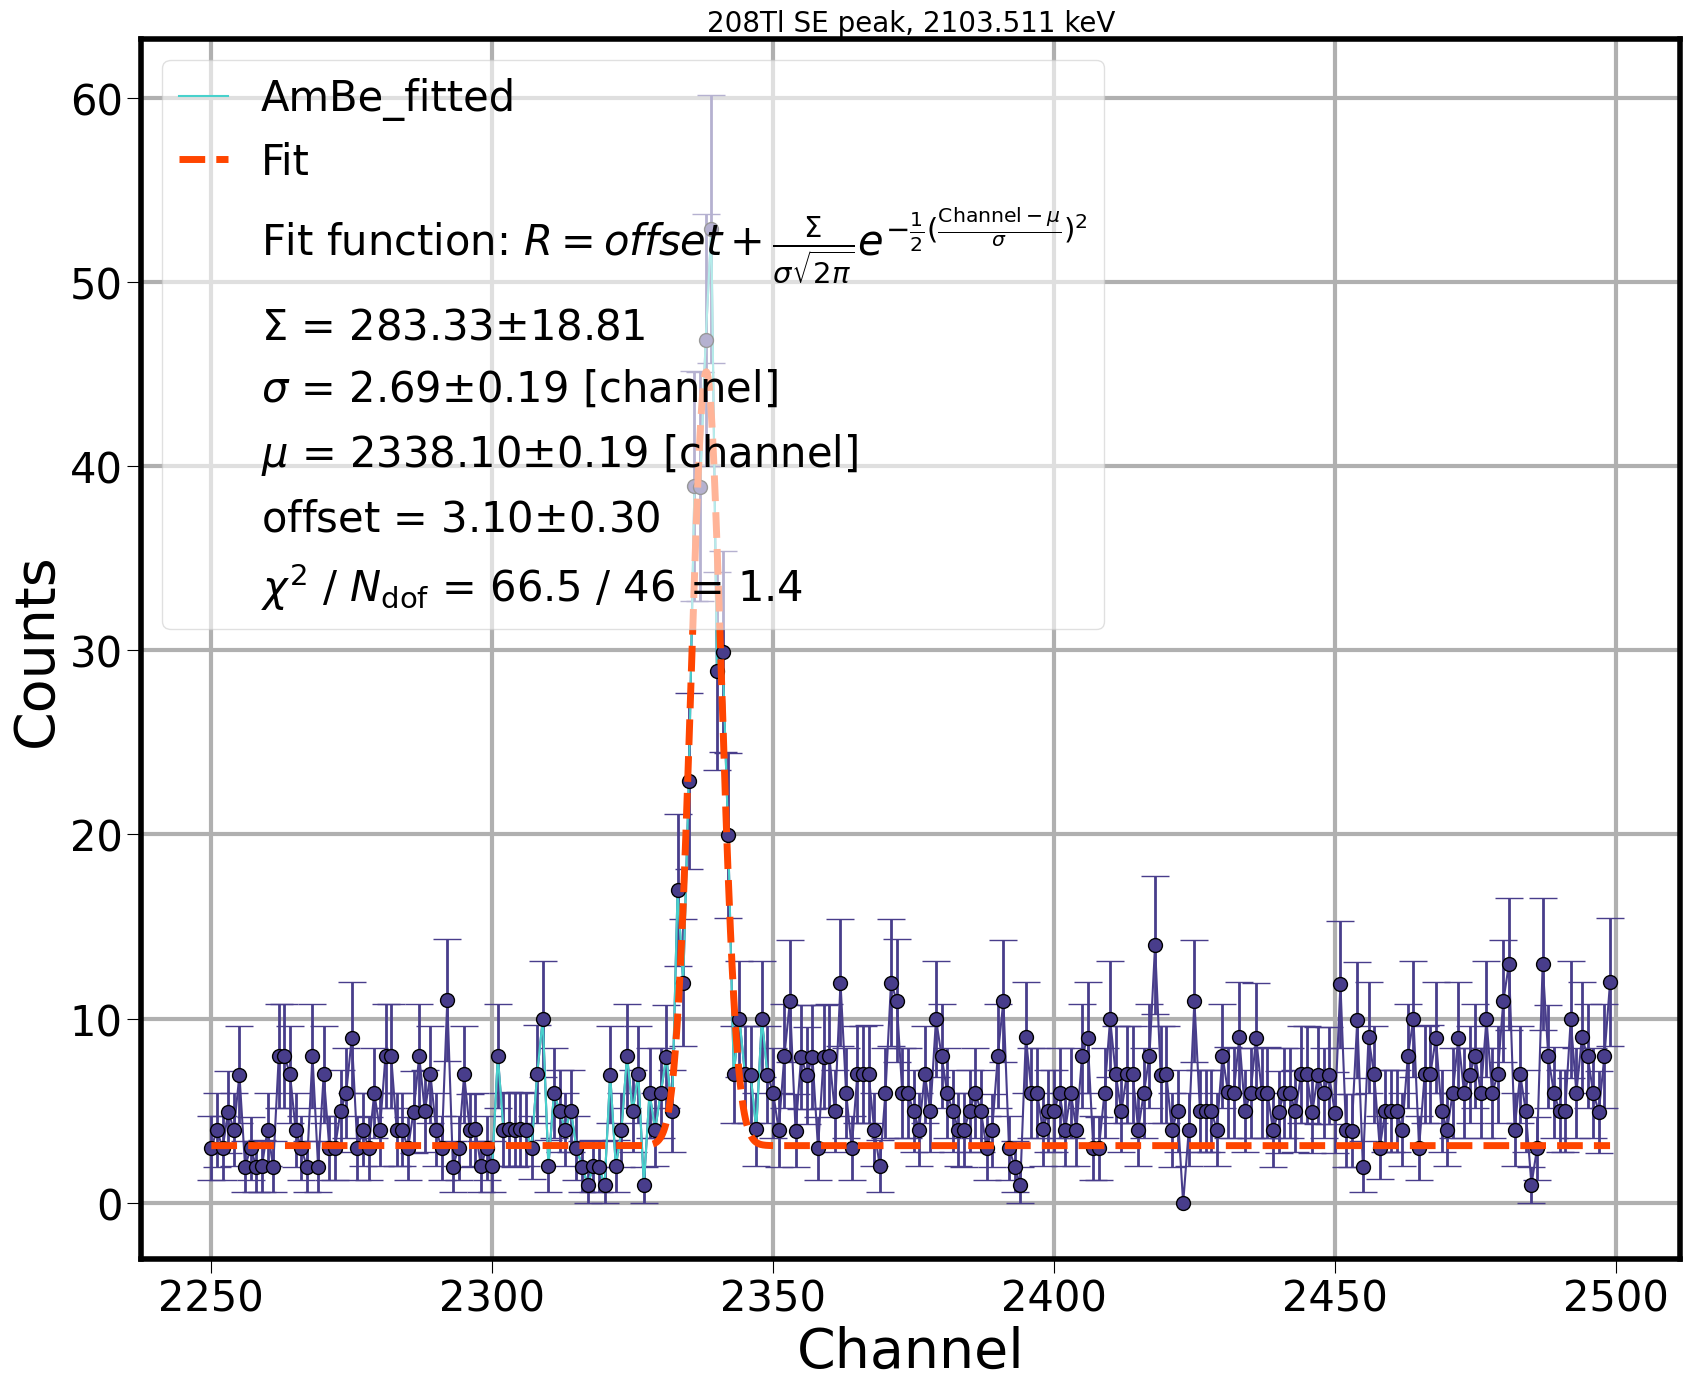

In [23]:
plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()



ch1=2300
ch2=2350
ch3=2250
ch4=2500

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 4000
mu00 = 2325
sig00 = 2 
offset00 = 0

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


In [24]:
popindex=[13,2]
print(Peak_energy)
for pi in popindex:
    Peak_name.pop(pi)
    Peak_energy.pop(pi) 
    Peak_channel.pop(pi)
    Peak_channel_err.pop(pi)
    Sigma_channel.pop(pi)
    Sigma_channel_err.pop(pi)
    print(Peak_energy)



[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]


'212Bi'

1512.7

1624.715167567177

0.2312738344241151

1.6273857940516259

0.20723962608975416

[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


'212Bi'

288.2

311.8810125249688

0.688849232431589

0.03256441751025158

0.20438038421802907

[115.183, 277.371, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th energy calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Channel')

setup complete
data stuff
fit funtion defined
least squares defined
minimizer created


/home/amslivar/.local/lib/python3.7/site-packages/iminuit/cost.py:83: RuntimeWarning: divide by zero encountered in true_divide
  z = (y - ym) / ye


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = inf (chi2/ndof = inf)      │              Nfcn = 210              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   1.234   │    nan    │            │            │         │         │       │
│ 1 │ p1   │    1.1    │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────┐
│    │  p0  p1 │
├────┼─────────┤
│ p0 │ nan nan │
│ p1 │ nan nan │
└────┴─────────┘

minimizer ran
<ValueView p0=1.234 p1=1.1>
<ErrorView p0=nan p1=nan>
^ errors
(1.234, 1.1)


ValueError: cannot convert float NaN to integer

<Figure size 1700x1400 with 0 Axes>

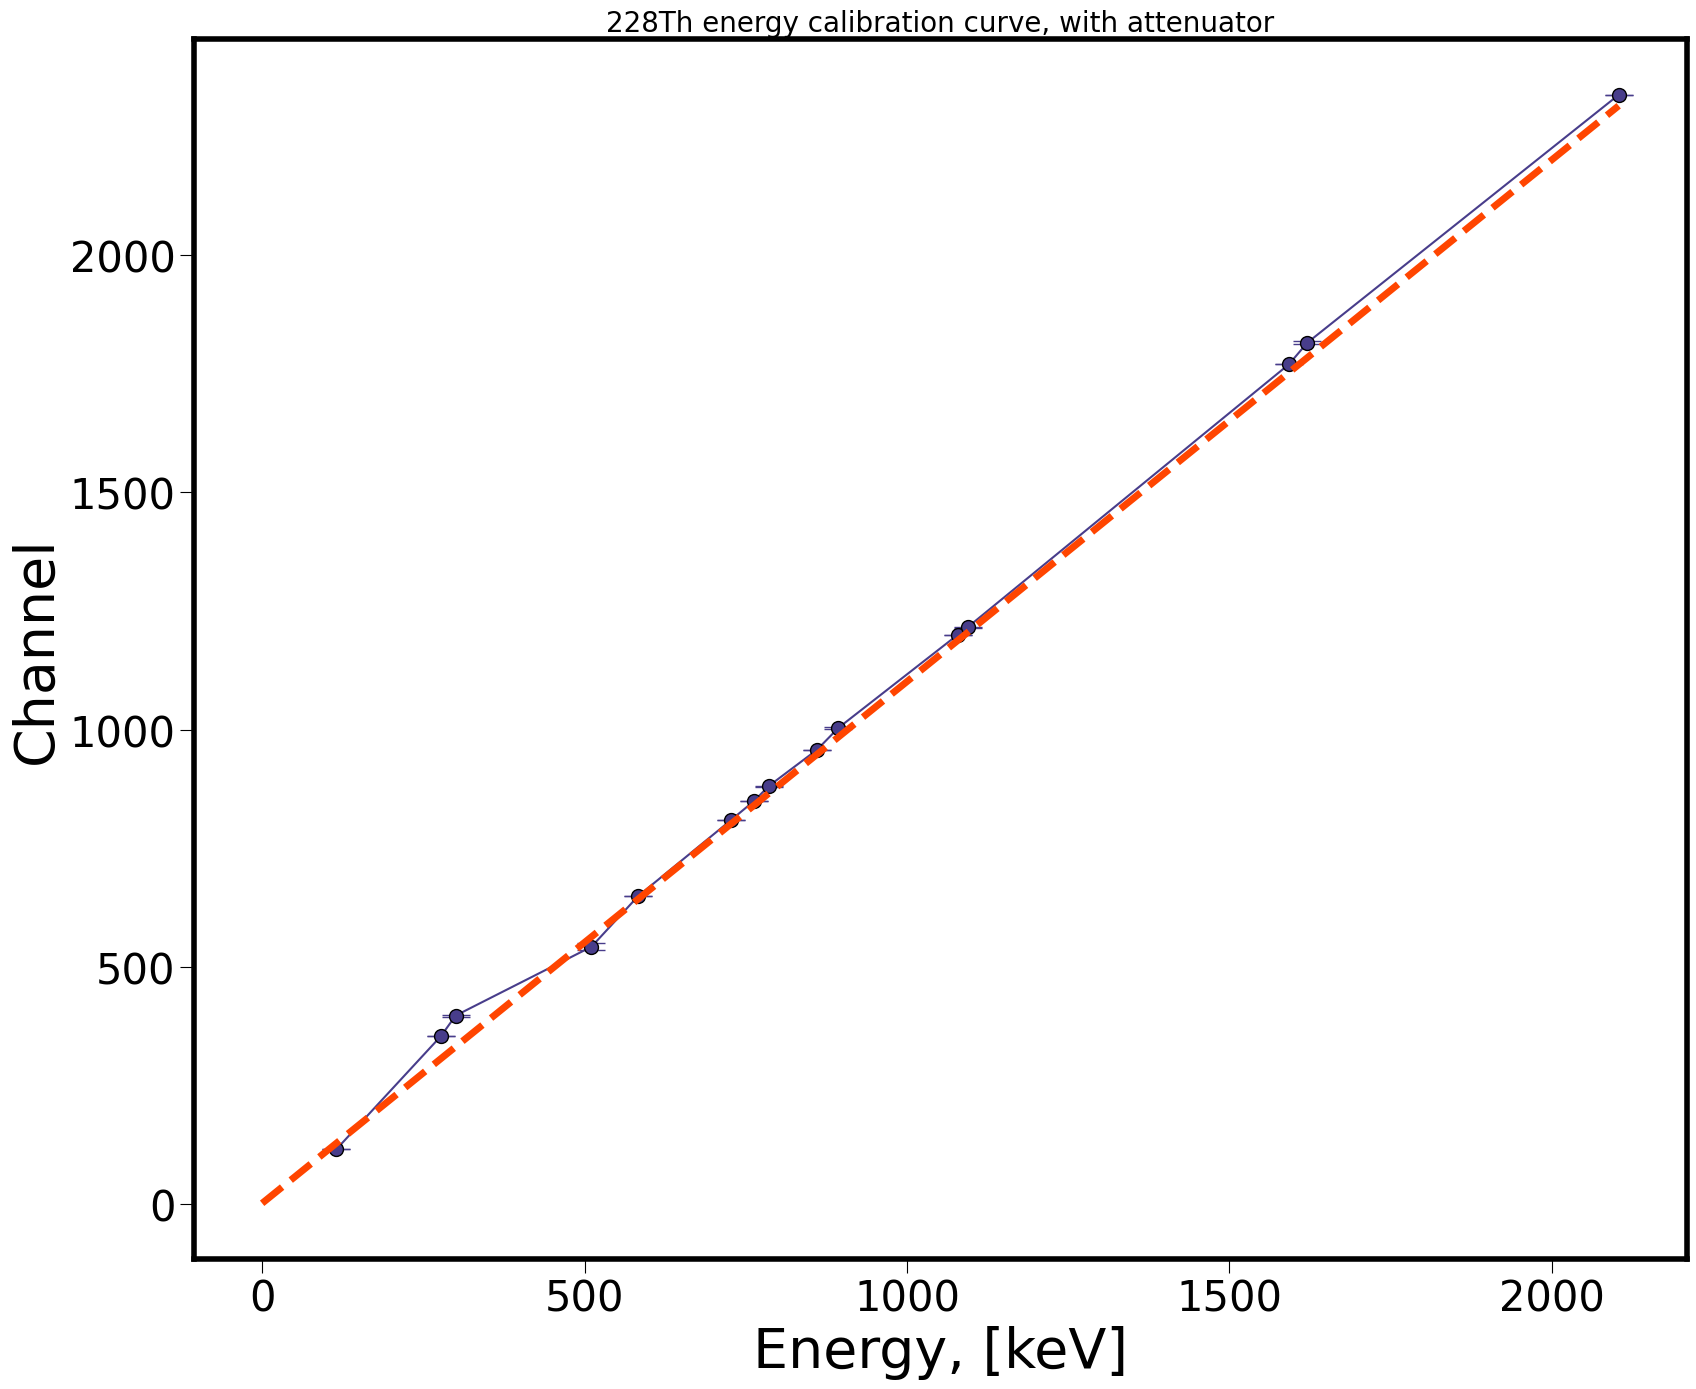

In [25]:
plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th energy calibration curve, with attenuator', fontsize=20)

#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Channel", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()

print("setup complete")

handlelist=[]
labellist=[]

Data, = ax1.plot(Peak_energy, Peak_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Peak_channel, yerr=Peak_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Peak_channel, label=r'228Th peaks positions', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

print("data stuff")

handlelist.append(data)
labellist.append(data.get_label())

#define fit function
def linear(x, p0, p1):
    return p0+p1*x

print("fit funtion defined")

#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Peak_channel, Peak_channel_err,linear)
print("least squares defined")

#set initial parameter values
p00=1.234
p10=1.1

#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)

#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist )     
print("minimizer created")

#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator
print("minimizer ran")

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error
print("^ errors")

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)
    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1


Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}e-5'.format(round(Decimal(minuit.values['p1']),number_sigdigs(minuit.errors['p1'])), 
                                        round(Decimal(minuit.errors['p1']*1e5),number_sigdigs(minuit.errors['p1']*1e5)))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration.png", bbox_inches ='tight')
plt.show()


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th resolution calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Sigma, [Channel]')

Peak_energy
Size of Peak_energy: 15
Sigma channel
14


ValueError: x and y must have same first dimension, but have shapes (15,) and (14,)

<Figure size 1700x1400 with 0 Axes>

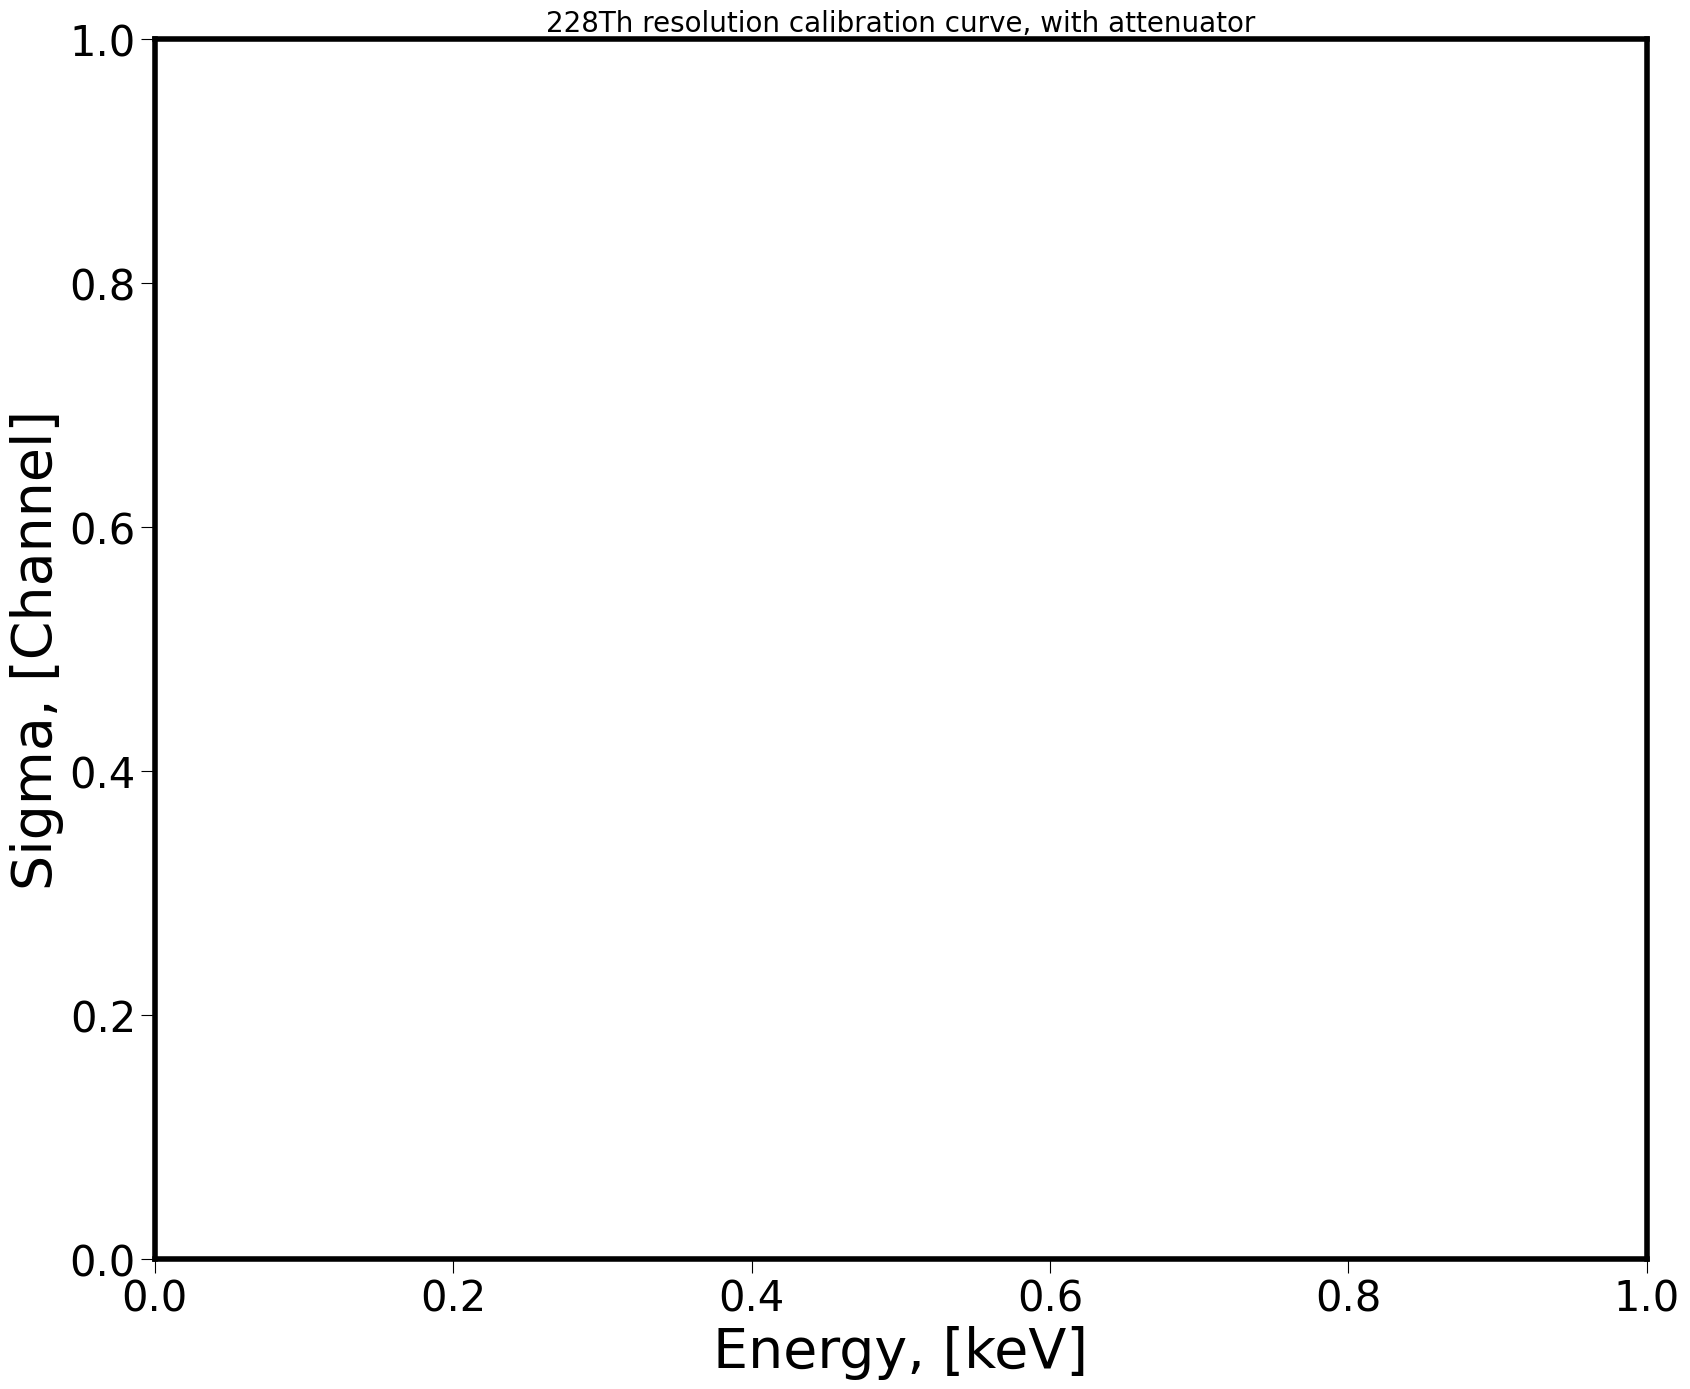

In [ ]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65

#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D
import iminuit
import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th resolution calibration curve, with attenuator', fontsize=20)

#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Sigma, [Channel]", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


handlelist=[]
labellist=[]

print("Peak_energy")
print("Size of Peak_energy:", len(Peak_energy))
print("Sigma channel")
print(len(Sigma_channel))

Data, = ax1.plot(Peak_energy, Sigma_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Sigma_channel, yerr=Sigma_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Sigma_channel, label=r'228Th peaks widths', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)

handlelist.append(data)
labellist.append(data.get_label())

#define fit function
def linear(x, p0, p1):
    return p0+p1*x

#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Sigma_channel, Sigma_channel_err,linear)

#set initial parameter values
p00=-0.41
p10=0.003

#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)

#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 

#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)

#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)

#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)

    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)

handlelist.append(Fit)
labellist.append(Fit.get_label())

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}'.format(round(minuit.values['p1'],7), round(minuit.errors['p1'],7))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]

for string in text:
    handlelist.append(extra)
    labellist.append(string)
fig.tight_layout()

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration_sigma.png", bbox_inches ='tight')
plt.show()
